<div class="alert alert-block alert-info">
<b>Work Note:</b><br>

- Due to computational time and my system limitation, I have used 15% of the random data in this exercise. I have checked the distribution and other descreptive of the sample data, and it matches the original data.
- I have used MinMax scaler because it preserves the shape of the original distribution. Doesn't reduce the importance of outliers. Least disruptive to the information in the original data.
- Large value of k in k-fold cross validatoin leads to **Less variance** across the training set and gives better model performance. However, to reduce the computation time and the number of times the model fits I have kept the k-fold cross validation to 5.
- Link to data: https://www.kaggle.com/edumagalhaes/quality-prediction-in-a-mining-process
</div>

# Context.
- The main goal is to use this data to **predict how much impurity is in the ore concentrate**. As this impurity is measured every hour, if we can predict how much silica (impurity) is in the ore concentrate, we can help the engineers, giving them early information to take actions (empowering!). Hence, they will be able to take corrective actions in advance (reduce impurity, if it is the case) and also help the environment (reducing the amount of ore that goes to tailings as you reduce silica in the ore concentrate).

# Content.
- The first column shows time and date range (from march of 2017 until september of 2017). Some columns were sampled every 20 second. Others were sampled on a hourly base.

- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. From column 9 until column 22, we can see process data (level and air flow inside the flotation columns, which also impact in ore quality. The last two columns are the final iron ore pulp quality measurement from the lab.
- Target is to predict the last column, which is the % of silica in the iron ore concentrate.



In [6]:
# import relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn; seaborn.set()
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px                                                     
sns.set_theme()
import time

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
from math import sqrt

from sklearn.linear_model import LassoCV, ElasticNet
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFECV

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.ensemble import ( AdaBoostRegressor,GradientBoostingRegressor, RandomForestRegressor)
from catboost import CatBoostRegressor
import lightgbm as lgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# bayes optimaization
from hyperopt import fmin, tpe, hp, anneal, Trials

pd.set_option('display.max_columns', None)

In [7]:
# function to create execution time of the models.

def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return f"{h}:{m}:{s}"

In [8]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [9]:
# import the data 
extract=pd.read_csv('MiningProcess_Flotation_Plant_Database.csv',
                    parse_dates=['date'])

<div class="alert alert-block alert-info">
<b>Note:</b><br>

- Due to computational time and my system limitation, I have used 15% of the random data in this exercise. I have checked the distribution and other descreptive of the sample data, and it matches the original data.
</div>

In [10]:
# let’s set frac=0.15 to get a random selection of 15% of the total rows:

sample_extract=extract.sample(frac=0.15)

In [11]:
# create a copy of the data.

data=sample_extract.copy()

In [12]:
# view the data.
data.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
662744,2017-08-23 16:00:00,"57,8","10,71","1096,7925416667","266,1154444444","378,850861678","9,59719","1,5375834862","300,11","297,589","297,473","298,7","300,655","291,212","291,086","855,5196666667","511,782","875,2712654867","392,194","359,772","377,357","354,681","64,65","2,46"
237886,2017-05-17 08:00:00,"64,03","6,26","3738,71","493,734","405,723","9,55015","1,66658","249,883","248,826","250,928","299,764","298,758","304,598","299,927","455,212","453,253","873,4037919243","346,488","349,32","350,76","350,46","64,93","1,91"
154535,2017-04-28 01:00:00,"53,01","20,32","2313,48","513,813","403,25","9,44707","1,72871","300,09","299,925","300,723","299,65","302,828","293,709","303,123","512,059","498,516","498,449","479,414","444,961","414,089","311,754","65,29","2,52"
680219,2017-08-27 18:00:00,"55,73","12,53","2199,22","389,768","379,1622693603","9,55133","1,7014","301,112","298,383","298,942","300,386","297,118","310,774","290,075","509,357","482,005","498,38","560,077","168,8561538462","537,224","178,62355","65,17","2,24"
242878,2017-05-18 12:00:00,"64,03","6,26","3510,21","590,073","404,2010599369","9,6427","1,73164","249,899","252,624","251,048","300,516","299,868","299,557","300,146","448,591","460,128","458,498","362,716","332,146","342,919","350,718","62,86","5,2159156493"


In [13]:
# get the basic info of the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110618 entries, 662744 to 296229
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          110618 non-null  datetime64[ns]
 1   % Iron Feed                   110618 non-null  object        
 2   % Silica Feed                 110618 non-null  object        
 3   Starch Flow                   110618 non-null  object        
 4   Amina Flow                    110618 non-null  object        
 5   Ore Pulp Flow                 110618 non-null  object        
 6   Ore Pulp pH                   110618 non-null  object        
 7   Ore Pulp Density              110618 non-null  object        
 8   Flotation Column 01 Air Flow  110618 non-null  object        
 9   Flotation Column 02 Air Flow  110618 non-null  object        
 10  Flotation Column 03 Air Flow  110618 non-null  object        
 11  Flotatio

- No missing values, all the values are in object format because of the special character comma.

In [14]:
# check the number of columns and rows

print("Data set contains {a} rows and {b} columns".format(a=data.shape[0],b=data.shape[1]))

Data set contains 110618 rows and 24 columns


In [15]:
# replace comma to dot.

data.replace(',','.', regex=True, inplace=True)

In [16]:
# view the tranformation.
data.head(3)

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
662744,2017-08-23 16:00:00,57.8,10.71,1096.7925416667,266.1154444444,378.850861678,9.59719,1.5375834862,300.11,297.589,297.473,298.7,300.655,291.212,291.086,855.5196666667,511.782,875.2712654867,392.194,359.772,377.357,354.681,64.65,2.46
237886,2017-05-17 08:00:00,64.03,6.26,3738.71,493.734,405.723,9.55015,1.66658,249.883,248.826,250.928,299.764,298.758,304.598,299.927,455.212,453.253,873.4037919243,346.488,349.32,350.76,350.46,64.93,1.91
154535,2017-04-28 01:00:00,53.01,20.32,2313.48,513.813,403.25,9.44707,1.72871,300.09,299.925,300.723,299.65,302.828,293.709,303.123,512.059,498.516,498.449,479.414,444.961,414.089,311.754,65.29,2.52


In [17]:
# lets tranform object data type to float data type.

for feature in data.columns:
    if data[feature].dtype=='object':
        data[feature]=pd.to_numeric(data[feature])

In [18]:
# chck tranformation.

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110618 entries, 662744 to 296229
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          110618 non-null  datetime64[ns]
 1   % Iron Feed                   110618 non-null  float64       
 2   % Silica Feed                 110618 non-null  float64       
 3   Starch Flow                   110618 non-null  float64       
 4   Amina Flow                    110618 non-null  float64       
 5   Ore Pulp Flow                 110618 non-null  float64       
 6   Ore Pulp pH                   110618 non-null  float64       
 7   Ore Pulp Density              110618 non-null  float64       
 8   Flotation Column 01 Air Flow  110618 non-null  float64       
 9   Flotation Column 02 Air Flow  110618 non-null  float64       
 10  Flotation Column 03 Air Flow  110618 non-null  float64       
 11  Flotatio

- We have tranformed the columns to float, now we hvae float and date columns only.

# Explore data (EDA)

In [19]:
data.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000,110618.000000
mean,56.290461,14.657130,2870.602114,488.052800,397.546621,9.767684,1.680377,280.191098,277.209591,281.102373,299.452760,299.898206,292.085614,290.738777,520.493304,522.559269,531.488335,420.356425,425.516101,430.066286,421.099047,65.047324,2.327472
std,5.163739,6.808673,1213.367991,91.246725,9.686688,0.386370,0.069271,29.543380,30.110117,28.495549,2.576258,3.647661,30.225867,28.636638,130.882617,127.850905,150.531221,91.983201,84.418204,89.762398,84.799697,1.116223,1.124673
min,42.740000,1.310000,0.017823,241.699000,376.250000,8.753340,1.519829,175.786916,176.092416,176.474834,292.533000,286.295000,190.146000,186.054000,149.441000,210.770000,126.353000,162.362556,167.267720,155.841000,175.377000,62.050000,0.600000
25%,52.610000,8.940000,2079.410034,431.276250,394.219000,9.528385,1.647190,250.288000,250.478000,250.859000,298.259000,298.044000,264.080250,256.385500,417.407000,441.853500,411.727250,356.644000,358.006250,358.747000,356.776000,64.370000,1.440000
50%,56.020000,13.930000,3021.090000,504.121000,399.229000,9.798030,1.697590,299.349000,296.225000,298.695000,299.809000,299.878000,299.487000,298.982000,492.060500,496.025000,494.439500,412.011000,408.937500,425.506000,411.257000,65.210000,2.000000
75%,59.720000,19.580000,3724.127500,553.559250,402.939000,10.038200,1.728250,300.152000,300.694000,300.388000,300.640000,301.778000,303.075000,301.900750,594.426500,595.682250,601.188000,485.669250,484.641500,492.694750,476.374500,65.860000,3.000000
max,65.780000,33.400000,6295.690000,739.504000,418.641000,10.808100,1.853196,373.549000,374.859000,361.006423,305.871000,310.270000,370.859000,371.590000,862.197932,828.903000,886.790500,680.274000,675.607000,698.861000,659.900000,68.010000,5.530000


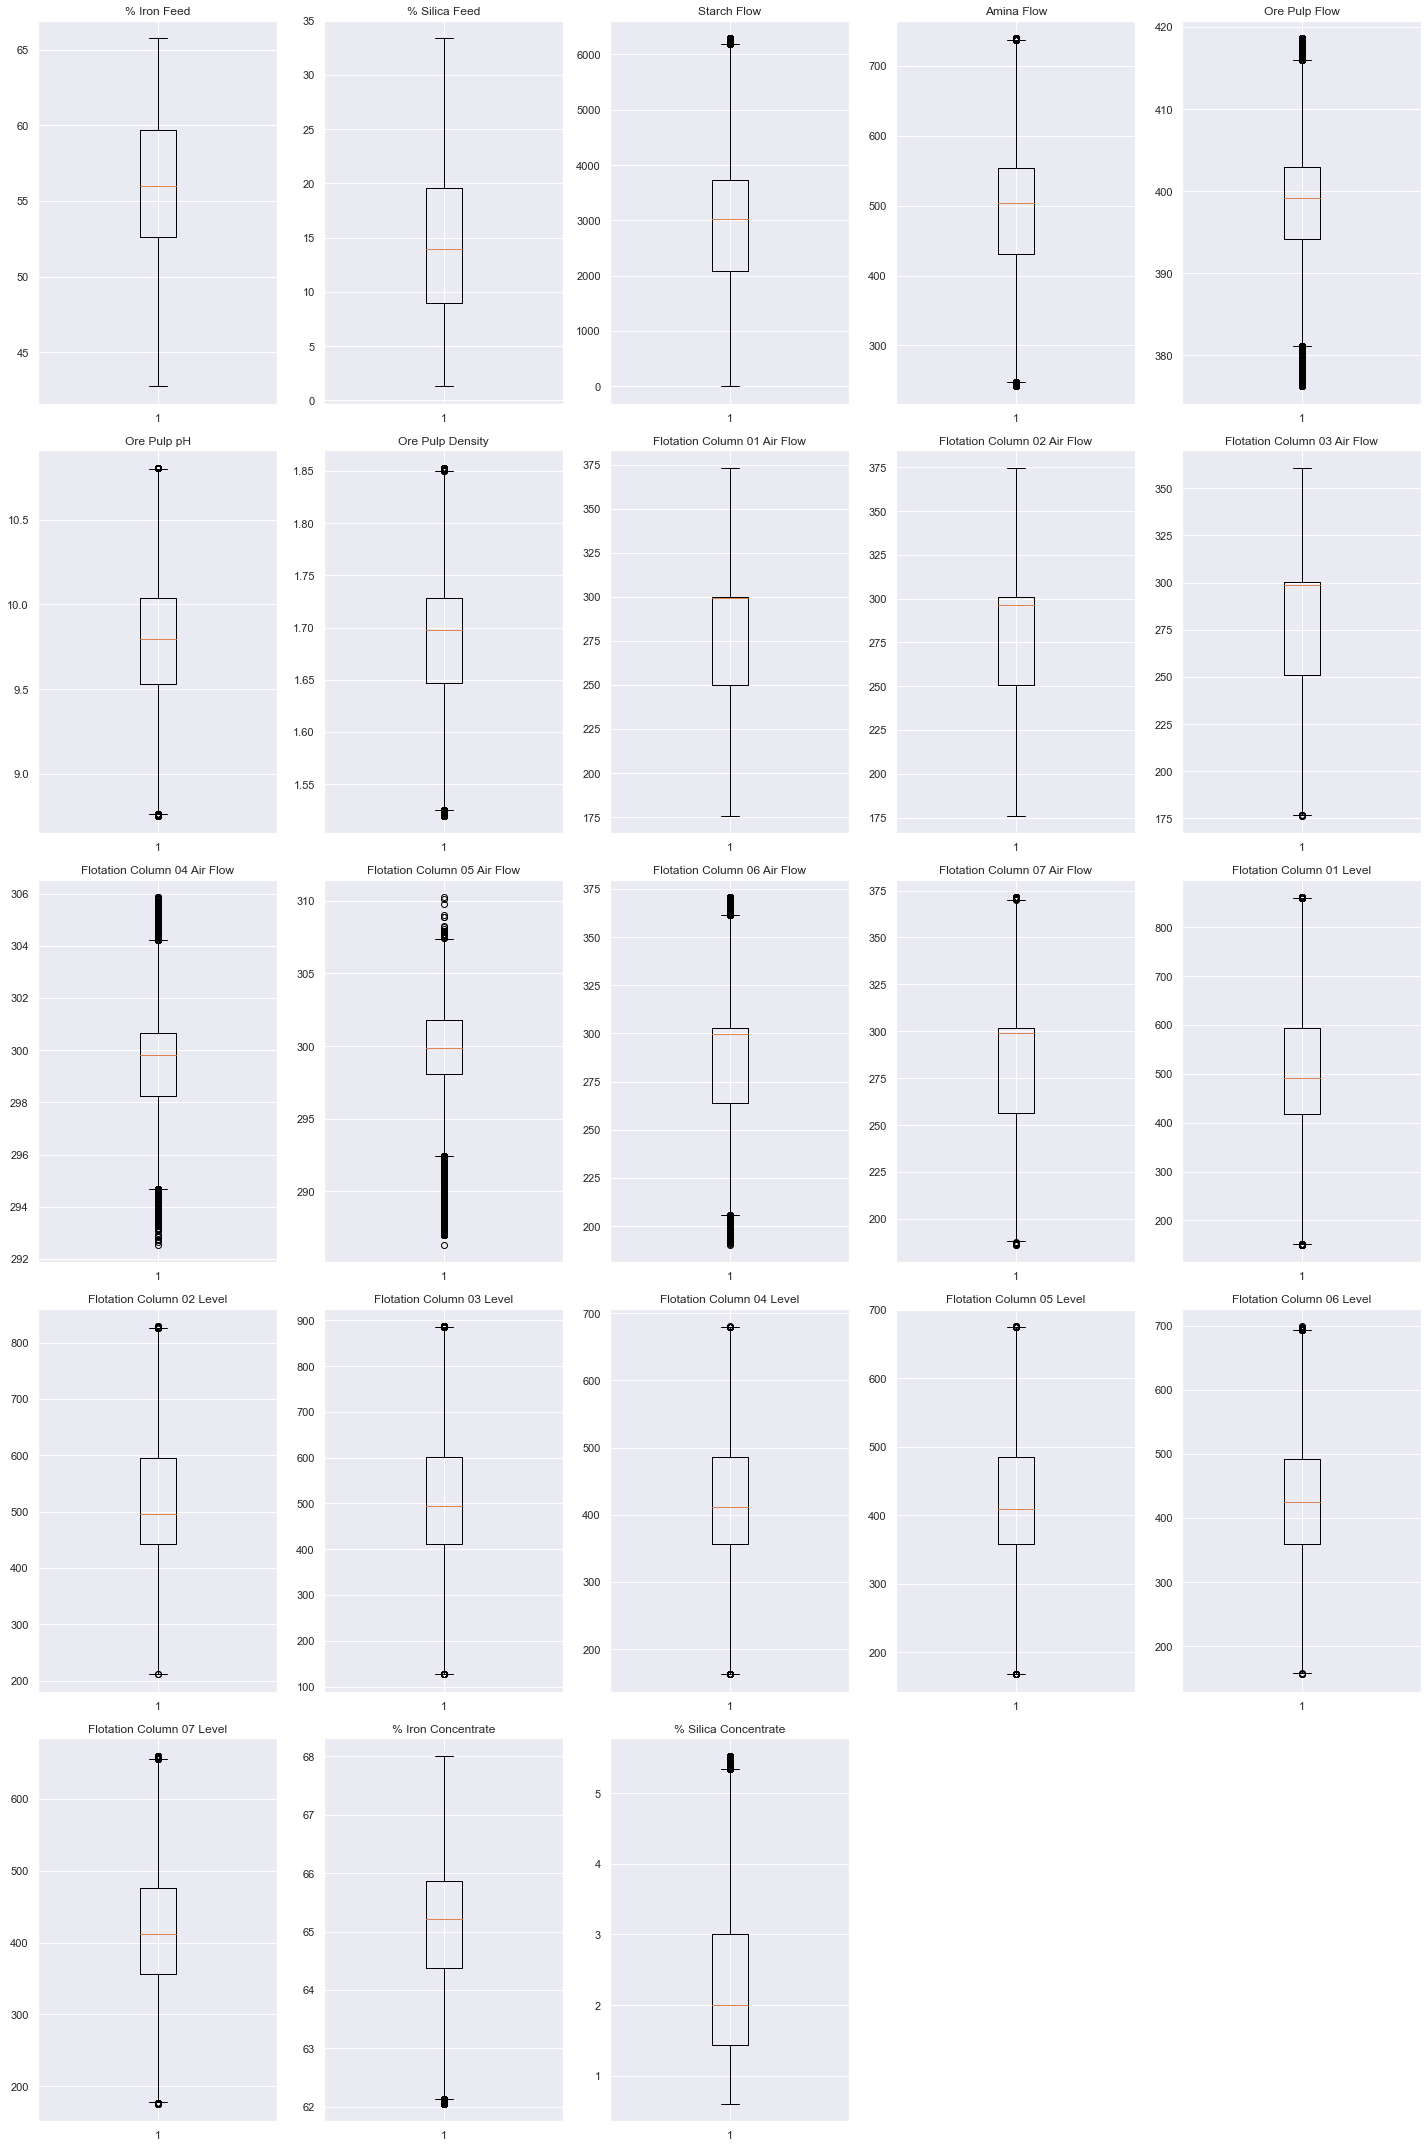

In [20]:
# Lets apply box plot to check the distribution of data.

numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(20,30))

for i, variable in enumerate(numeric_columns):
                     plt.subplot(5,5,i+1)
                     plt.boxplot(data[variable],whis=1.5)
                     plt.tight_layout()
                     plt.title(variable)

plt.show()

- Data looks normally distributed with min and max outliers. Target variable % Silica Concentrate is right skewed.

In [21]:
# lets separeate day, month and year to see get better insight

data['day']=data['date'].apply(lambda date: date.day)
data['month']=data['date'].apply(lambda date: date.month)
data['year']=data['date'].apply(lambda date: date.year)

In [22]:
data.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,day,month,year
662744,2017-08-23 16:00:00,57.80,10.71,1096.792542,266.115444,378.850862,9.59719,1.537583,300.110,297.589,297.473,298.700,300.655,291.212,291.086,855.519667,511.782,875.271265,392.194,359.772000,377.357,354.68100,64.65,2.460000,23,8,2017
237886,2017-05-17 08:00:00,64.03,6.26,3738.710000,493.734000,405.723000,9.55015,1.666580,249.883,248.826,250.928,299.764,298.758,304.598,299.927,455.212000,453.253,873.403792,346.488,349.320000,350.760,350.46000,64.93,1.910000,17,5,2017
154535,2017-04-28 01:00:00,53.01,20.32,2313.480000,513.813000,403.250000,9.44707,1.728710,300.090,299.925,300.723,299.650,302.828,293.709,303.123,512.059000,498.516,498.449000,479.414,444.961000,414.089,311.75400,65.29,2.520000,28,4,2017
680219,2017-08-27 18:00:00,55.73,12.53,2199.220000,389.768000,379.162269,9.55133,1.701400,301.112,298.383,298.942,300.386,297.118,310.774,290.075,509.357000,482.005,498.380000,560.077,168.856154,537.224,178.62355,65.17,2.240000,27,8,2017
242878,2017-05-18 12:00:00,64.03,6.26,3510.210000,590.073000,404.201060,9.64270,1.731640,249.899,252.624,251.048,300.516,299.868,299.557,300.146,448.591000,460.128,458.498000,362.716,332.146000,342.919,350.71800,62.86,5.215916,18,5,2017


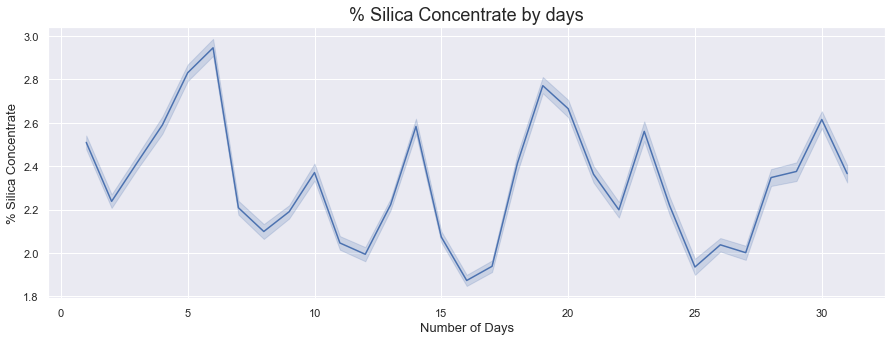

In [23]:
from seaborn import lineplot
plt.figure(figsize=(15,5))
plt.title('% Silica Concentrate by days', fontsize=18)
lineplot(x='day', y='% Silica Concentrate', data=data)
plt.ylabel('% Silica Concentrate', fontsize=13)
plt.xlabel('Number of Days', fontsize=13)
plt.show()

- As we can observe during the 4th to 6th and 13th to 14th, and 18th to 20th day of the month there is an increase in % Silica Concentrate.

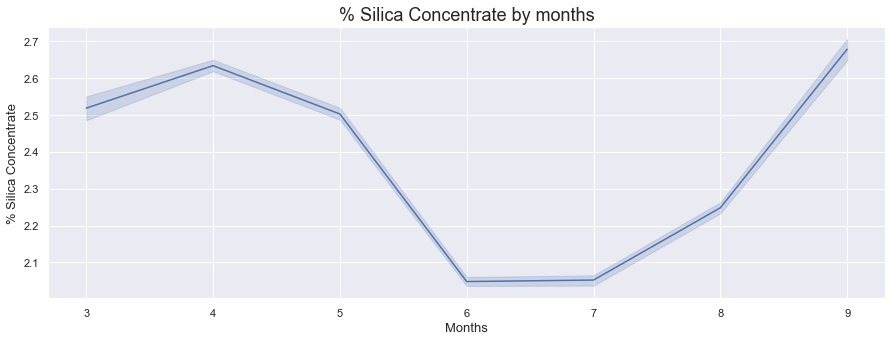

In [24]:
from seaborn import lineplot
plt.figure(figsize=(15,5))
plt.title('% Silica Concentrate by months', fontsize=18)
lineplot(x='month', y='% Silica Concentrate', data=data)
plt.ylabel('% Silica Concentrate', fontsize=13)
plt.xlabel('Months', fontsize=13)
plt.show()

- Between mid of May to Mid of August month percent of Silica Concentration is less, when we pass August month we can see the percent of Silica increases significantly. We need more insight from this as what leads to increase in perecent of silica after July month.

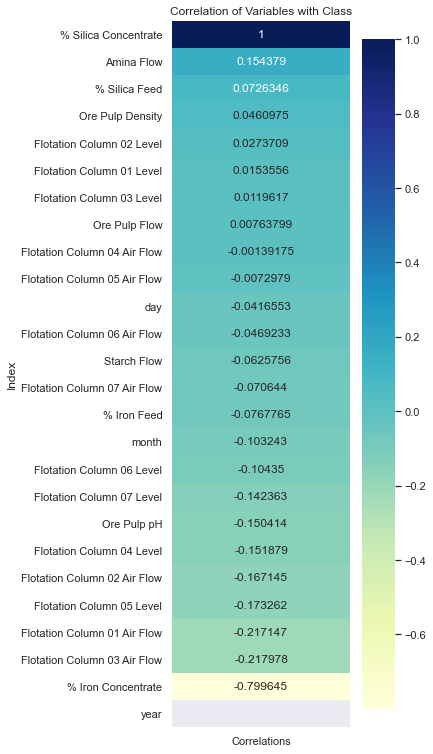

In [25]:
# correlation chart against the target varaible.

corr = data.corrwith(data['% Silica Concentrate']).reset_index()
corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)
plt.figure(figsize=(4,13))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Correlation of Variables with Class")
plt.show()

- From the above chart, we can observe that Amina Flow and Silica Feed having a strong positive correlation. This indicates that increases in these variables will increase the % of Silica Concentrate, leading to Iron Ore Concentration's impurity.
- Flotation Colum 03 Air Flow, Floatation Column 01 Air Flow Floatation Column 05 Level and so on negatively correlated. This indicates that increases in these variables will decrease the % of Silica concentrate, which leads to purity of Iron ore concentration.
- **Amina Flow is one of the significant contributors to the impurity of the Iron ore concentrate, Amina Flow should be minimized.**

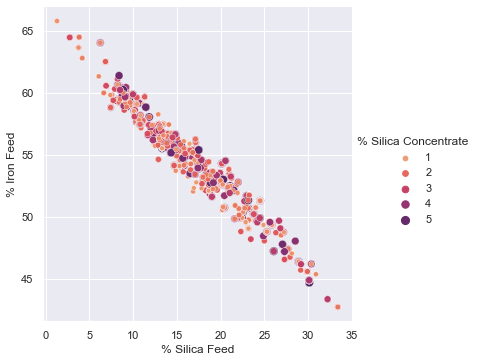

In [26]:
# check the how Silica feed and Iron feed affects the silica concnetrate

sns.relplot(x='% Silica Feed', y= '% Iron Feed', data=data, size='% Silica Concentrate', hue='% Silica Concentrate', palette='flare');

- As we can observe above that we have linear downwards trend. When the percent of Iron Feed decrease there is a increase in % Silica Feed. We can also observe that majority of the silica concentrate in the Iron Feed are in between 41% to 62%, in Silica Feed we can observe that majority of the Silica Concentrate are in between 8% to 30%.

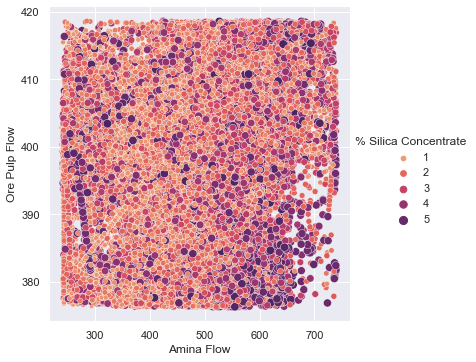

In [27]:
# check the how Amina Flow and Ore Pulp Flow affects the silica concnetrate

sns.relplot(x='Amina Flow', y= 'Ore Pulp Flow', data=data, size='% Silica Concentrate', hue='% Silica Concentrate', palette='flare');

- We can observe non linearity in Amina Flow and Ore Pulp Flow, also we can observe that % Silica Concentrate is scattered across. This indicates that increase or decrase in Amina Flow and Ore Pulp score will not affect the % Silica Concentrate.

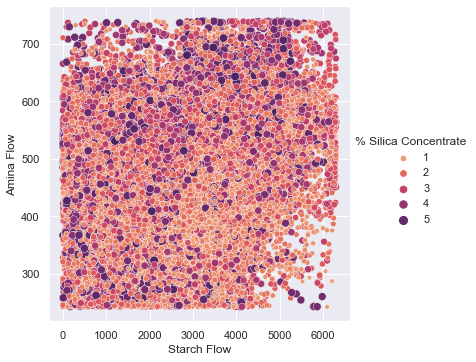

In [28]:
# check the how Starch Flow and Amina Flow affects the silica concnetrate

sns.relplot(x='Starch Flow', y= 'Amina Flow', data=data, size='% Silica Concentrate', hue='% Silica Concentrate', palette='flare');

- We can observe non linearity in Amina Flow and Starch Flow, also we can observe that % Silica Concentrate is scattered across. This indicates that increase or decrase in Amina Flow and Starch Flow will not affect the % Silica Concentrate.

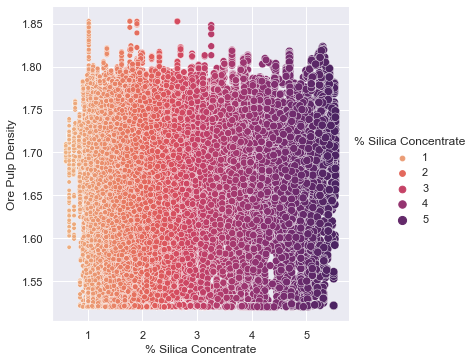

In [29]:
# check the how % Silica Concentrate and Ore Puplp Density distributed.

sns.relplot(x='% Silica Concentrate', y= 'Ore Pulp Density', data=data,
            size='% Silica Concentrate', hue='% Silica Concentrate', palette='flare');

- We just see randomness here, there is no patterns.

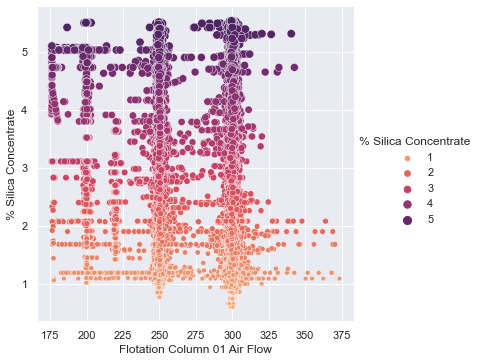

In [30]:
# check the how Flotation Column 01 Air Flow and % Silica Concentrate distributed.

sns.relplot(x='Flotation Column 01 Air Flow', y= '% Silica Concentrate', data=data,
            size='% Silica Concentrate', hue='% Silica Concentrate', palette='flare');

- From the above we can observe that when the Floatation column 01 Air Flow is 250 and 300 we can see higher percentage of Silica Concentrate.

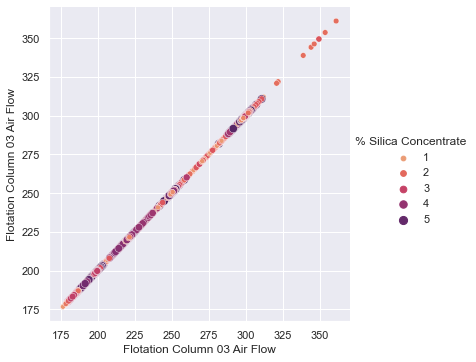

In [31]:
# check the how Flotation Column 03 Air Flow and Flotation Column 01 Air Flow affects the silica concnetrate

sns.relplot(x='Flotation Column 03 Air Flow', y= 'Flotation Column 03 Air Flow', data=data,
            size='% Silica Concentrate', hue='% Silica Concentrate', palette='flare');

- We can observe the linear trend here; this indicates that one variable affects the increase in another variable. Also, the majority of the Silica Concentrate is between 190 to 250 and a few between 280 to 300 Floatation column airflow.

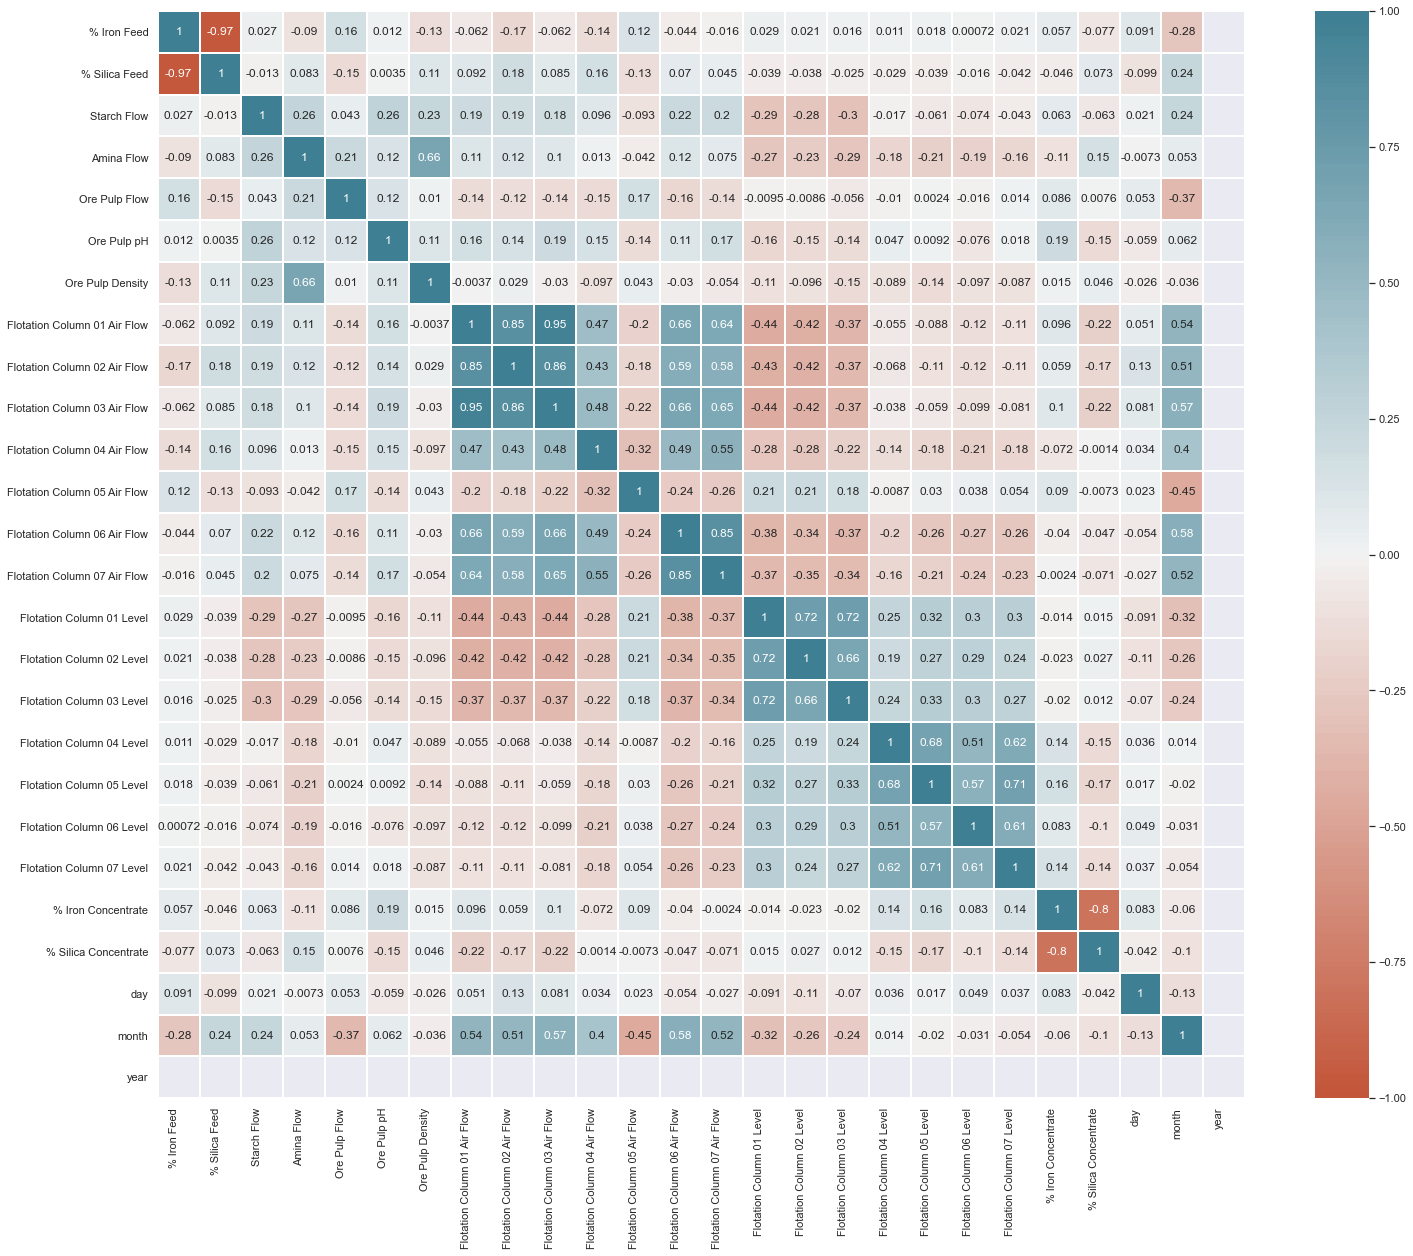

In [32]:
# Apply correlation plot to see the correlation between numerical variables.

plt.figure(figsize=(25,20))
corr = data.corr()
ax = sns.heatmap(data.dropna().corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200),
                 linecolor='white', linewidths=2, annot = True,square=True)
ax.set_xticklabels( ax.get_xticklabels(), rotation=90, horizontalalignment='right');

- % of Iron Feed and % of Silica Feed having negative correlation.
- Ore pulp density and Amina Flow having positive correlation by 66%.
- Flotation column 01 Air Flow, 2 and 3 having positive correlation.
- % silica and Iron concentrate having negative correlation.

- **From the correlation chart we can observe that few variables are having significant positive and negative correlation.**

--------------

# Removal of Unwanted variables.

In [33]:
# In the earlier section we had created few variables such as Day, month and year column from Date column to get better insight.
# Now we can drop those variables. Also i will be remove year column from the model.

df=data.drop(['date','year'],axis=1)

In [34]:
# view the data

df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,day,month
662744,57.80,10.71,1096.792542,266.115444,378.850862,9.59719,1.537583,300.110,297.589,297.473,298.700,300.655,291.212,291.086,855.519667,511.782,875.271265,392.194,359.772000,377.357,354.68100,64.65,2.460000,23,8
237886,64.03,6.26,3738.710000,493.734000,405.723000,9.55015,1.666580,249.883,248.826,250.928,299.764,298.758,304.598,299.927,455.212000,453.253,873.403792,346.488,349.320000,350.760,350.46000,64.93,1.910000,17,5
154535,53.01,20.32,2313.480000,513.813000,403.250000,9.44707,1.728710,300.090,299.925,300.723,299.650,302.828,293.709,303.123,512.059000,498.516,498.449000,479.414,444.961000,414.089,311.75400,65.29,2.520000,28,4
680219,55.73,12.53,2199.220000,389.768000,379.162269,9.55133,1.701400,301.112,298.383,298.942,300.386,297.118,310.774,290.075,509.357000,482.005,498.380000,560.077,168.856154,537.224,178.62355,65.17,2.240000,27,8
242878,64.03,6.26,3510.210000,590.073000,404.201060,9.64270,1.731640,249.899,252.624,251.048,300.516,299.868,299.557,300.146,448.591000,460.128,458.498000,362.716,332.146000,342.919,350.71800,62.86,5.215916,18,5


# Feature selection.
- Lasso: Lasso involves a penalty factor that determines how many features are retained. Lasso does both parameter shrinkage and variable selection automatically because it zero's out the co-eficients of collinear variables. 


In [35]:
# scale the data using standard scaler.

scaler=MinMaxScaler()
subset=df.copy()
subset_scaled=scaler.fit_transform(subset)

scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)
scaled_df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,day,month
0,0.653646,0.292926,0.174211,0.049048,0.061354,0.410681,0.053258,0.628650,0.611253,0.655704,0.462363,0.598957,0.559262,0.566100,0.990630,0.486970,0.984852,0.443766,0.378693,0.407933,0.370063,0.436242,0.377282,0.733333,0.833333
1,0.924045,0.154254,0.593851,0.506293,0.695266,0.387787,0.440208,0.374673,0.365925,0.403471,0.542135,0.519833,0.633336,0.613752,0.428998,0.392283,0.982396,0.355515,0.358131,0.358954,0.361351,0.483221,0.265720,0.533333,0.333333
2,0.445747,0.592396,0.367469,0.546628,0.636928,0.337621,0.626579,0.628549,0.623005,0.673317,0.533588,0.689593,0.573080,0.630977,0.508754,0.465508,0.489318,0.612173,0.546275,0.475577,0.281467,0.543624,0.389452,0.900000,0.166667
3,0.563802,0.349642,0.349320,0.297444,0.068700,0.388362,0.544657,0.633716,0.615247,0.663665,0.588769,0.451429,0.667511,0.560651,0.504963,0.438797,0.489228,0.767920,0.003125,0.702337,0.006701,0.523490,0.332657,0.866667,0.833333
4,0.924045,0.154254,0.557556,0.699820,0.659363,0.432829,0.635368,0.374754,0.385032,0.404121,0.598516,0.566131,0.605441,0.614932,0.419708,0.403405,0.436781,0.386849,0.324347,0.344514,0.361884,0.135906,0.936291,0.566667,0.333333


In [36]:
# Define X and Y variables

X = df.drop(['% Silica Concentrate'],axis=1)
y = df['% Silica Concentrate']

In [37]:
lasso = LassoCV(cv=10, random_state=1).fit(X, y)

print("Best alpha using built-in LassoCV: %f" %lasso.alpha_)
print("Best score using built-in LassoCV: %f" %lasso.score(X,y))
coef = pd.Series(lasso.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.085392
Best score using built-in LassoCV: 0.675245


In [38]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 20 variables and eliminated the other 4 variables


In [39]:
# Lets check which variables are picked and dropped by Lasso.
# we drop the one wiht 0 coefficient.

imp_coef = coef.sort_values()
imp_coef.sort_values(ascending=False)

% Silica Feed                   0.008511
day                             0.002679
Flotation Column 05 Air Flow    0.002468
Ore Pulp Flow                   0.002052
Flotation Column 07 Air Flow    0.001132
Amina Flow                      0.000903
Flotation Column 06 Air Flow    0.000365
Flotation Column 07 Level       0.000068
Flotation Column 04 Air Flow    0.000000
Ore Pulp pH                     0.000000
Ore Pulp Density               -0.000000
% Iron Feed                    -0.000000
Starch Flow                    -0.000016
Flotation Column 03 Level      -0.000029
Flotation Column 02 Level      -0.000096
Flotation Column 04 Level      -0.000139
Flotation Column 06 Level      -0.000200
Flotation Column 01 Level      -0.000281
Flotation Column 05 Level      -0.000312
Flotation Column 03 Air Flow   -0.001127
Flotation Column 02 Air Flow   -0.001317
Flotation Column 01 Air Flow   -0.004926
month                          -0.020468
% Iron Concentrate             -0.708419
dtype: float64

In [40]:
# get only features which is not equal to 0.

imp_features = pd.Series(imp_coef)
imp_features = imp_features[imp_features != 0] 
imp_features

% Iron Concentrate             -0.708419
month                          -0.020468
Flotation Column 01 Air Flow   -0.004926
Flotation Column 02 Air Flow   -0.001317
Flotation Column 03 Air Flow   -0.001127
Flotation Column 05 Level      -0.000312
Flotation Column 01 Level      -0.000281
Flotation Column 06 Level      -0.000200
Flotation Column 04 Level      -0.000139
Flotation Column 02 Level      -0.000096
Flotation Column 03 Level      -0.000029
Starch Flow                    -0.000016
Flotation Column 07 Level       0.000068
Flotation Column 06 Air Flow    0.000365
Amina Flow                      0.000903
Flotation Column 07 Air Flow    0.001132
Ore Pulp Flow                   0.002052
Flotation Column 05 Air Flow    0.002468
day                             0.002679
% Silica Feed                   0.008511
dtype: float64

In [41]:
# from above series create a data frame.
imp_feature_df=pd.DataFrame({'Feature_name':imp_features.index, 'Feature_value':imp_features.values})

# sort by highest feature value to lowest.
imp_feature_df.sort_values(ascending=False,by='Feature_value',inplace=True)
imp_feature_df

,Feature_name,Feature_value
19,% Silica Feed,0.008511
18,day,0.002679
17,Flotation Column 05 Air Flow,0.002468
16,Ore Pulp Flow,0.002052
15,Flotation Column 07 Air Flow,0.001132
14,Amina Flow,0.000903
13,Flotation Column 06 Air Flow,0.000365
12,Flotation Column 07 Level,0.000068
11,Starch Flow,-0.000016
10,Flotation Column 03 Level,-0.000029


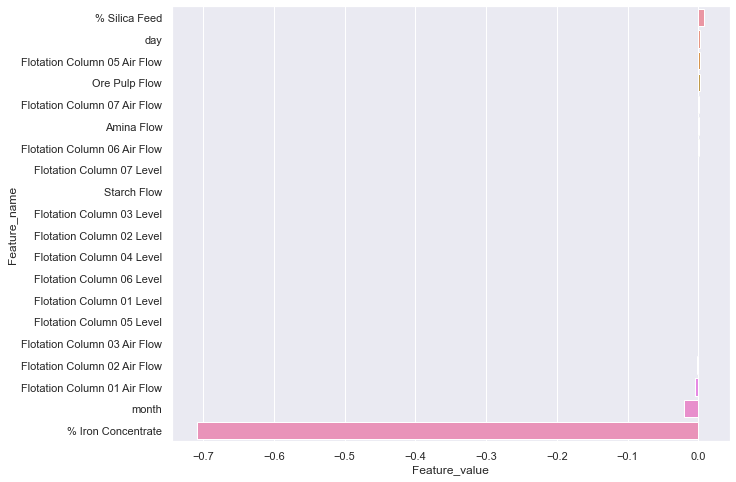

In [42]:
# apply diverging bar chart for data frame.

plt.figure(figsize=(10,8))
ax=sns.barplot(x='Feature_value',y='Feature_name',data=imp_feature_df,ci=None)
ax.set_xlabel('Feature_value');

- From the above, we can observe that % Iron Concentrate, Flotation column 01 Air Flow, months and so on having a negative affect on % Silica Concentrate. Feature such as Amina Flow and % Silica Feed having a positive affect on % Silica Concentrate.
- Out of 20 variables Lasso picked 22 variables as the essential features to predict the % of Silica Concentrate.

In [43]:
# get the list of important features.
imp_feature_df['Feature_name'].unique()

array(['% Silica Feed', 'day', 'Flotation Column 05 Air Flow',
       'Ore Pulp Flow', 'Flotation Column 07 Air Flow', 'Amina Flow',
       'Flotation Column 06 Air Flow', 'Flotation Column 07 Level',
       'Starch Flow', 'Flotation Column 03 Level',
       'Flotation Column 02 Level', 'Flotation Column 04 Level',
       'Flotation Column 06 Level', 'Flotation Column 01 Level',
       'Flotation Column 05 Level', 'Flotation Column 03 Air Flow',
       'Flotation Column 02 Air Flow', 'Flotation Column 01 Air Flow',
       'month', '% Iron Concentrate'], dtype=object)

In [44]:
# data frame with important features only.

df=df[['% Silica Feed', 'day', 'Ore Pulp Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 05 Air Flow',
       'Amina Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Level', 'Starch Flow',
       'Flotation Column 03 Level', 'Flotation Column 02 Level',
       'Flotation Column 04 Level', 'Flotation Column 06 Level',
       'Flotation Column 01 Level', 'Flotation Column 05 Level',
       'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow',
       'Flotation Column 01 Air Flow', 'month', '% Iron Concentrate','% Silica Concentrate']]

------------------------


# Model Building approach.
- Building basic models as a benchmark to compare this model with the other tuned models (hyperparameters) models and also to compare the performance score of the models.

## Lasso Basic Model

In [45]:
# scale the data using standard scaler.

scaler=MinMaxScaler()
subset=df.copy()
subset_scaled=scaler.fit_transform(subset)

scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)
scaled_df.head()

,% Silica Feed,day,Ore Pulp Flow,Flotation Column 07 Air Flow,Flotation Column 05 Air Flow,Amina Flow,Flotation Column 06 Air Flow,Flotation Column 07 Level,Starch Flow,Flotation Column 03 Level,Flotation Column 02 Level,Flotation Column 04 Level,Flotation Column 06 Level,Flotation Column 01 Level,Flotation Column 05 Level,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 01 Air Flow,month,% Iron Concentrate,% Silica Concentrate
0,0.377065,0.000000,0.523425,0.624731,0.773428,0.524939,0.618278,0.665264,0.598969,0.460338,0.449508,0.613315,0.518274,0.507175,0.605092,0.656230,0.660193,0.626707,0.666667,0.295302,0.527383
1,0.366158,0.300000,0.587544,0.346506,0.853306,0.634718,0.331401,0.755765,0.331457,0.622731,0.981413,0.898313,0.352030,0.725597,0.617680,0.336177,0.398706,0.373797,0.166667,0.657718,0.184584
2,0.154254,0.800000,0.983204,0.594735,0.645554,0.378556,0.588625,0.514259,0.254705,0.523934,0.335452,0.361679,0.506253,0.387130,0.424059,0.364751,0.659197,0.617832,0.333333,0.587248,0.111562
3,0.295731,0.833333,0.496485,0.587665,0.551882,0.659420,0.598926,0.440206,0.622546,0.471288,0.449435,0.742730,0.385136,0.483588,0.653217,0.602195,0.655483,0.643801,0.666667,0.622483,0.223124
4,0.426301,0.466667,0.243973,0.880697,0.438059,0.659286,0.929939,0.703664,0.392383,0.514672,0.486472,0.960910,0.632022,0.525399,0.616053,0.619074,0.670793,0.623395,0.833333,0.364094,0.174442


In [46]:
# Define X and Y variables

X = scaled_df.drop(['% Silica Concentrate'],axis=1)
y = scaled_df['% Silica Concentrate']

In [47]:
# split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(77432, 20) (33186, 20)


In [48]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

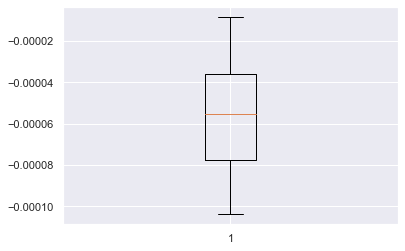

In [49]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='r2'
#scoring='neg_mean_squared_error' > this is MSE

cv_result_bfr=cross_val_score(estimator=lasso, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Lasso model not able to explain the model performance.

## Ridge Basic model Model

In [50]:
ridge = Ridge()
ridge.fit(X_train,y_train)

Ridge()

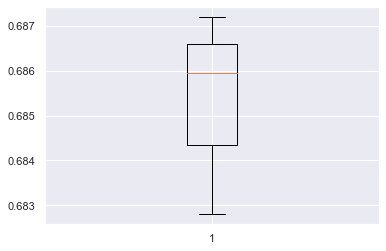

In [51]:
# Let's evaluate the model performance by using KFold and cross_val_score

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=ridge, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Peformance of Ridge basic model varies between 0.683 to 0.687.

In [52]:
# prediction on Xtest data.

ridge_pred = ridge.predict(X_test)

In [53]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, ridge_pred))
print('MSE:', metrics.mean_squared_error(y_test, ridge_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ridge_pred)))

MAE: 0.09764111839240806
MSE: 0.01619609524299927
RMSE: 0.12726388035495095


- model error evaluation metrics MAE, MSE and RMSE is low.

In [54]:
# model variance check.

print('Ridge Basic R-square on test data is {a}.'.format(a=r2_score(y_test, ridge_pred)))

Ridge Basic R-square on test data is 0.6867234651116514.


In [55]:
# performance on training and test.

print('Training Accuracy is {a:.3f}%'.format(a=ridge.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=ridge.score(X_test, y_test)))

Training Accuracy is 0.686%
Test Accuracy is 0.687%


## ElasticNet Basic Model

In [56]:
elasticnet = ElasticNet(random_state=1)
elasticnet.fit(X_train, y_train)

ElasticNet(random_state=1)

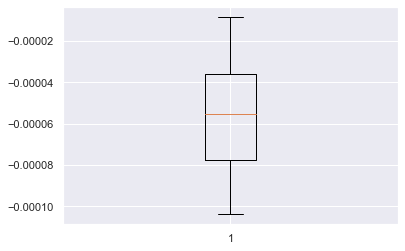

In [57]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=elasticnet, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- ElasticNet model not able to explain the model performance.

## Decision Tree Basic Model

In [58]:
dtree = DecisionTreeRegressor(random_state=1)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

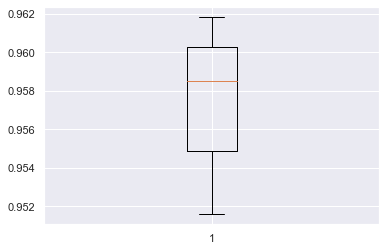

In [59]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=dtree, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Peformance on training set varies between 0.952 to 0.962.

In [60]:
# predict on X test

dtree_pred = dtree.predict(X_test)

In [61]:
# model eror evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, dtree_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtree_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtree_pred)))

MAE: 0.008794870197398766
MSE: 0.0017048995259520828
RMSE: 0.04129042898726148


- Decision Tree basic model error evaluation metrics is low for MAE, MSE and RMSE.

In [62]:
# model variance check

print('Decision Tree Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, dtree_pred)))

Decision Tree Basic model R-square on test data is 0.96702260589299.


In [63]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=dtree.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=dtree.score(X_test, y_test)))

Training Accuracy is 1.000%
Test Accuracy is 0.967%


- Decision Tree basic model overfits the training data.

## ExtraTree Regressor Basic.

In [64]:
ext_tree=ExtraTreesRegressor(random_state=1)
ext_tree.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

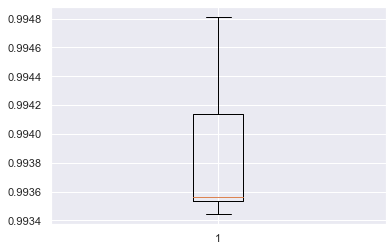

In [65]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=ext_tree, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.9934 to 0.9948

In [66]:
# predict on X test

ext_tree_pred = ext_tree.predict(X_test)

In [67]:
# model eror evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, ext_tree_pred))
print('MSE:', metrics.mean_squared_error(y_test, ext_tree_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ext_tree_pred)))

MAE: 0.006265600187520028
MSE: 0.00022346697243647476
RMSE: 0.014948811739950262


- Extra Tree basic model error evaluation metrics is low for MAE, MSE and RMSE.

In [68]:
# model variance check  
print('Extra Tree Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, ext_tree_pred)))

Extra Tree Basic model R-square on test data is 0.9956775409296788.


In [69]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=ext_tree.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=ext_tree.score(X_test, y_test)))

Training Accuracy is 1.000%
Test Accuracy is 0.996%


- Extra tree basic model overfits the training data.

## Random Forest Basic Model

In [70]:
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

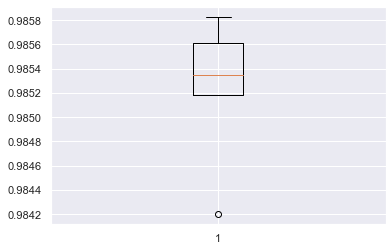

In [71]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2'
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=rf, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.9842 to 0.9858.


In [72]:
# predict on X test
rf_pred = rf.predict(X_test)

In [73]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, rf_pred))
print('MSE:', metrics.mean_squared_error(y_test, rf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_pred)))

MAE: 0.011047380808115398
MSE: 0.000579573848547773
RMSE: 0.02407434004386772


- RandomForest basic model error evaluation metrics is low for MAE, MSE and RMSE.

In [74]:
# model variance check
print('RandomForest Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, rf_pred)))

RandomForest Basic model R-square on test data is 0.988789465345764.


In [75]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=rf.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=rf.score(X_test, y_test)))

Training Accuracy is 0.998%
Test Accuracy is 0.989%


## Bagging Basic Model

In [76]:
bg = BaggingRegressor(random_state=1)
bg.fit(X_train, y_train)

BaggingRegressor(random_state=1)

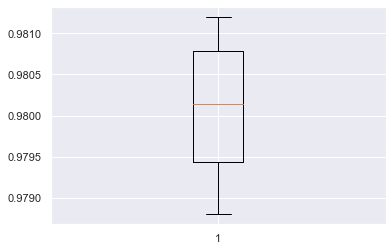

In [77]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2'
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=bg, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.9790 to 0.9810

In [78]:
# prediction on test data.
bg_pred = bg.predict(X_test)

In [79]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, bg_pred))
print('MSE:', metrics.mean_squared_error(y_test, bg_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, bg_pred)))

MAE: 0.012446995639667995
MSE: 0.0007802938740395461
RMSE: 0.02793374078134803


- Bagging Basic model able to lower the errors, good MAE, MSE and RMSE score.

In [80]:
print('Bagging basic model R-square on test data is {a}.'.format(a=r2_score(y_test, bg_pred)))

Bagging basic model R-square on test data is 0.9849069941003603.


In [81]:
# performance on training and test.

print('Training Accuracy is {a:.3f}%'.format(a=bg.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=bg.score(X_test, y_test)))

Training Accuracy is 0.997%
Test Accuracy is 0.985%


## AdbaBoost Basic Model

In [82]:
abr = AdaBoostRegressor(random_state=1)
abr.fit(X_train,y_train)

AdaBoostRegressor(random_state=1)

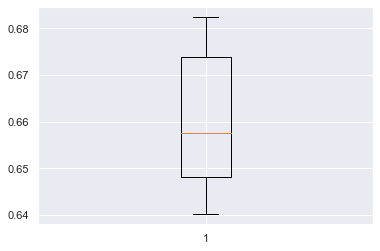

In [83]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2'
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=abr, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.64 to 0.69

In [84]:
# prediction on test data
abr_pred = abr.predict(X_test)

In [85]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, abr_pred))
print('MSE:', metrics.mean_squared_error(y_test, abr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, abr_pred)))

MAE: 0.11189336903125183
MSE: 0.01806127818472144
RMSE: 0.13439225492833073


- Comparing to previous models Adboost Regressor having slightly higher errors.

In [86]:
print('AdbBoost Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, bg_pred)))

AdbBoost Basic model R-square on test data is 0.9849069941003603.


In [87]:
# performance on training and test.

print('Training Accuracy is {a:.3f}%'.format(a=abr.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=abr.score(X_test, y_test)))

Training Accuracy is 0.652%
Test Accuracy is 0.651%


- Training and test score for AdaBoost basic model is comparitively less.

## Gradient Boost Basic Model

In [88]:
gbr = GradientBoostingRegressor(random_state=1)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

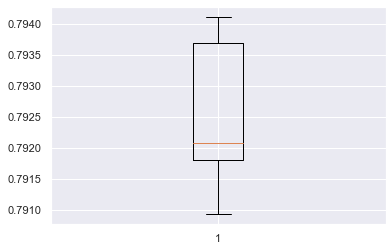

In [89]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2'
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=gbr, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.710 to 0.7940

In [90]:
# prediction on test data
gbr_pred = gbr.predict(X_test)

In [91]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, gbr_pred))
print('MSE:', metrics.mean_squared_error(y_test, gbr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gbr_pred)))

MAE: 0.07563365147040757
MSE: 0.010557478821460296
RMSE: 0.10274959280435274


In [92]:
print('GradientBoost Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, gbr_pred)))

GradientBoost Basic model R-square on test data is 0.7957896435701791.


In [93]:
# performance on training and test.

print('Training Accuracy is {a:.3f}%'.format(a=gbr.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=gbr.score(X_test, y_test)))

Training Accuracy is 0.794%
Test Accuracy is 0.796%


- Training and Test score for Gradient Boost basic model is low.

## XGBoost Basic Model

In [94]:
xgb = XGBRegressor(reg='squarederror', random_state=1)
xgb.fit(X_train, y_train)

[17:17:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "reg" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=1,
             reg='squarederror', reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

[17:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "reg" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "reg" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "reg" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

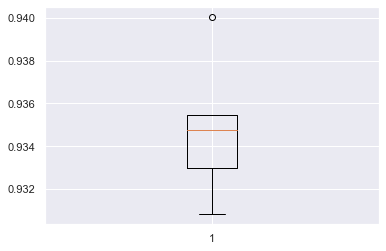

In [95]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2'
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=xgb, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.932 to 0.940

In [96]:
# prediction on test data
xgb_pred = xgb.predict(X_test)

In [97]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, xgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, xgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb_pred)))

MAE: 0.039335168789694404
MSE: 0.003034933705254142
RMSE: 0.05509023239426516


In [98]:
print('XGBoost Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, xgb_pred)))

XGBoost Basic model R-square on test data is 0.9412961272125857.


In [99]:
# performance on training and test.

print('Training Accuracy is {a:.3f}%'.format(a=xgb.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=xgb.score(X_test, y_test)))

Training Accuracy is 0.951%
Test Accuracy is 0.941%


## CatBoostRegressor Basic Model

In [100]:
cat=CatBoostRegressor(random_state=1,verbose=False)
cat.fit(X_train, y_train)

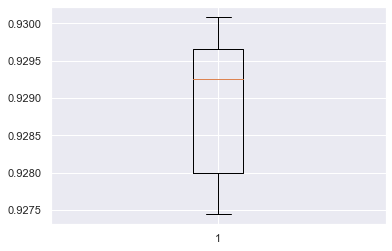

In [101]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2'
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=cat, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.9275 to 0.9300

In [102]:
# prediction on test data
cat_pred = cat.predict(X_test)

In [103]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, cat_pred))
print('MSE:', metrics.mean_squared_error(y_test, cat_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, cat_pred)))

MAE: 0.04294573024699993
MSE: 0.0035025752921891275
RMSE: 0.0591825590202817


In [104]:
print('CatBoost Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, cat_pred)))

CatBoost Basic model R-square on test data is 0.932250666950304.


In [105]:
# performance on training and test.

print('Training Accuracy is {a:.3f}%'.format(a=cat.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=cat.score(X_test, y_test)))

Training Accuracy is 0.939%
Test Accuracy is 0.932%


## LightGBM Regressor Basic Model

In [106]:
lgbm=LGBMRegressor(random_state=1)
lgbm.fit(X_train, y_train)

LGBMRegressor(random_state=1)

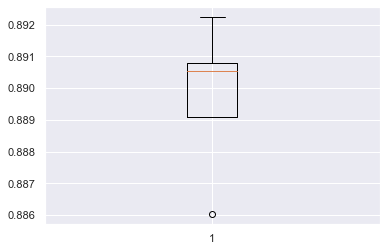

In [107]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2'
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=lgbm, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.886 to 0.891

In [108]:
# prediction on test data
lgbm_pred = lgbm.predict(X_test)

In [109]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, lgbm_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgbm_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgbm_pred)))

MAE: 0.055079181407350394
MSE: 0.0055718678351056065
RMSE: 0.07464494514101813


In [110]:
print('LightGBM Regressor Basic model R-square on test data is {a}.'.format(a=r2_score(y_test, lgbm_pred)))

LightGBM Regressor Basic model R-square on test data is 0.892224920757228.


In [111]:
# performance on training and test.

print('Training Accuracy is {a:.3f}%'.format(a=lgbm.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=lgbm.score(X_test, y_test)))

Training Accuracy is 0.896%
Test Accuracy is 0.892%


## Linear Regression Model
- Linear regressoin using Stats model

In [113]:
# build ordinary least square model.
import statsmodels.api as sm

X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [114]:
# first OLS model

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                             OLS Regression Results                             
Dep. Variable:     % Silica Concentrate   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.686
Method:                   Least Squares   F-statistic:                     8441.
Date:                  Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                          19:01:58   Log-Likelihood:                 49144.
No. Observations:                 77432   AIC:                        -9.825e+04
Df Residuals:                     77411   BIC:                        -9.805e+04
Df Model:                            20                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

- We have few variables having the P value > 0.05, this indicates that these variables are insignificant (not important) to our model.
- Both the R-squared and Adjusted R squared of our model around 67%. This is a clear indication that we have been able to create a decent model that is able to explain variance in % Silica Concentrate by 67%
- The model is not an underfitting model.
- To be able to make statistical inferences from our model, we will have to test that the linear regression assumptions are followed.
- Before we move on to assumption testing, we'll do a quick performance check on the test data.

**Checking the Linear Regression Assumptions**

     1) No Multicollinearity
     2) Mean of residuals should be 0 
     3) No Heteroscedasticity
     4) Linearity of variables
     5) Normality of error terms

**Checking Assumption 1: No Multicollinearity**

- We will use VIF, to check if there is multicollinearity in the data.
Features having a VIF score >10 will be dropped/treated till all the features have a VIF score <10

In [115]:
# Function to create VIF 

from statsmodels.stats.outliers_influence import variance_inflation_factor

def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))]
    
    return vif


# print(checking_vif(x_train))

In [116]:
# Check VIF
vif_check=checking_vif(X_train)

In [117]:
# we dont need infinity value, lets exclude them.
vif_filter=vif_check.loc[(vif_check['VIF'])!=np.inf]

# view the 20 highest VIF
vif_filter.nlargest(20,'VIF')

,feature,VIF
0,const,119.139924
17,Flotation Column 03 Air Flow,13.232081
18,Flotation Column 01 Air Flow,11.549863
7,Flotation Column 06 Air Flow,4.559705
16,Flotation Column 02 Air Flow,4.412341
4,Flotation Column 07 Air Flow,3.932298
14,Flotation Column 01 Level,2.960423
15,Flotation Column 05 Level,2.693601
19,month,2.538398
10,Flotation Column 03 Level,2.451342


- As we see from the above vif table that some independint variables are having VIF score (2 variables having > 10 VIF score).
- Lets drop one by one of these variables and see how this affects the model. (Flotation Column 03 Air Flow and Flotation Column 01 Air Flow)

In [118]:
 # we drop the one with the highest vif values and check the Adjusted-R Squared

X_train_1 = X_train.drop('Flotation Column 03 Air Flow', axis=1)
vif_series = pd.Series([variance_inflation_factor(X_train_1.values,i) for i in range(X_train_1.shape[1])],index=X_train_1.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series))

Series before feature selection: 

const                           118.849760
% Silica Feed                     1.146087
day                               1.120135
Ore Pulp Flow                     1.270819
Flotation Column 07 Air Flow      3.916384
Flotation Column 05 Air Flow      1.307477
Amina Flow                        1.259646
Flotation Column 06 Air Flow      4.559622
Flotation Column 07 Level         2.404575
Starch Flow                       1.228000
Flotation Column 03 Level         2.450741
Flotation Column 02 Level         2.389409
Flotation Column 04 Level         2.067126
Flotation Column 06 Level         1.793198
Flotation Column 01 Level         2.956674
Flotation Column 05 Level         2.682600
Flotation Column 02 Air Flow      3.980150
Flotation Column 01 Air Flow      4.491362
month                             2.434766
% Iron Concentrate                1.110287
dtype: float64



- No variables with high Multicollinearity.

In [119]:
olsmod_2 = sm.OLS(y_train, X_train_1)
olsres_2= olsmod_2.fit()
print(olsres_2.summary())

                             OLS Regression Results                             
Dep. Variable:     % Silica Concentrate   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.685
Method:                   Least Squares   F-statistic:                     8883.
Date:                  Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                          19:10:07   Log-Likelihood:                 49138.
No. Observations:                 77432   AIC:                        -9.824e+04
Df Residuals:                     77412   BIC:                        -9.805e+04
Df Model:                            19                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

- Removing those multicollienarity variables not affecting the R square or Adjusted R square dropped by 0.05%.

In [121]:
 # we can drop few variables which are having the p value of 0.05 or greater than 0.05 which are insignificant to the model.

X_train_2 = X_train_1.drop('Starch Flow', axis=1)

olsmod_2 = sm.OLS(y_train, X_train_2)
olsres_2= olsmod_2.fit()
print(olsres_2.summary())

                             OLS Regression Results                             
Dep. Variable:     % Silica Concentrate   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.685
Method:                   Least Squares   F-statistic:                     9377.
Date:                  Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                          19:21:26   Log-Likelihood:                 49138.
No. Observations:                 77432   AIC:                        -9.824e+04
Df Residuals:                     77413   BIC:                        -9.806e+04
Df Model:                            18                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

- No change in R square or the Adjusted R square, we can remove.
- Lets remove Ore Pulp Flow.

In [122]:
X_train_3 = X_train_2.drop('Ore Pulp Flow', axis=1)

olsmod_3 = sm.OLS(y_train, X_train_3)
olsres_3= olsmod_3.fit()
print(olsres_3.summary())

                             OLS Regression Results                             
Dep. Variable:     % Silica Concentrate   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.685
Method:                   Least Squares   F-statistic:                     9928.
Date:                  Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                          19:24:28   Log-Likelihood:                 49136.
No. Observations:                 77432   AIC:                        -9.824e+04
Df Residuals:                     77414   BIC:                        -9.807e+04
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

- No change after removing the variable and we can conclude here that ols model 3 as the final regression model.


**Checking Assumption 2: Mean of residuals should be 0**

In [123]:
residuals = olsres_3.resid
np.mean(residuals)

-4.1777604094325295e-16

- Mean of redisuals is very close to 0. The second assumption is also satisfied

**Checking Assumption 3: No Heteroscedasticity**


- Homoscedacity - If the residuals are symmetrically distributed across the regression line , then the data is said to homoscedastic.
- Heteroscedasticity- - If the residuals are not symmetrically distributed across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form a funnel shape or any other non symmetrical shape.<br>

     - We'll use Goldfeldquandt Test to test the following hypothesis.<br>
    - Null hypothesis : Residuals are homoscedastic Alternate hypothesis : Residuals have hetroscedasticity<br>
    - alpha = 0.05<br>


In [124]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residuals, X_train_3)
lzip(name, test)

[('F statistic', 0.9886005958618425), ('p-value', 0.8702690172583081)]

- Since p-value > 0.05 we cannot reject the Null Hypothesis that the residuals are homoscedastic.
- Assumptions 3 is also satisfied by our ols model 3.

**Checking Assumption 4: Linearity of variables**
- Predictor variables must have a linear relation with the dependent variable.
- To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x axis.

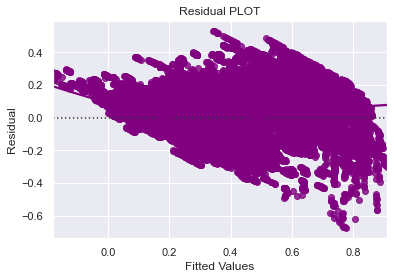

In [125]:
# predicted values
fitted = olsres_3.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(fitted, residuals, color="purple", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

- Assumptions 4 is satisfactory for ols model 3. There is slight downward pattern for residual vs fitted values plot. Ideally, we should not have any patterns for residuals and Fitted values.

**Checking Assumption 5: Normality of error terms.**
- The residuals should be normally distributed.

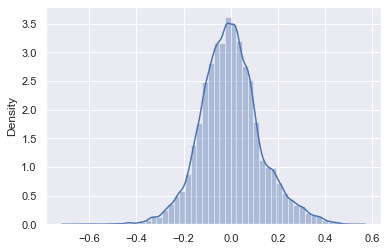

In [127]:
# Plot histogram of residuals
sns.distplot(residuals);

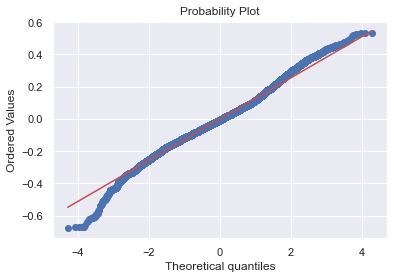

In [128]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

- The residuals have a close to normal distribution. Assumption 5 is also satisfied. We should further investigate these values in the tails where we have made residual errors.

- Now that we have seen that ols model 3 follows all the linear regression assumptions. Let us use that model to draw inferences.

In [129]:
print(olsres_3.summary())

                             OLS Regression Results                             
Dep. Variable:     % Silica Concentrate   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.685
Method:                   Least Squares   F-statistic:                     9928.
Date:                  Fri, 23 Jul 2021   Prob (F-statistic):               0.00
Time:                          20:41:42   Log-Likelihood:                 49136.
No. Observations:                 77432   AIC:                        -9.824e+04
Df Residuals:                     77414   BIC:                        -9.807e+04
Df Model:                            17                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

#### Coefficeint Analysis

In [181]:
# Positive coefficient analysis for % Silica Feed on % Silica Concentrate
# changge in odds

silica_feed_coef=(np.exp(0.0855)-1)*100
silica_feed_coef

8.926156134406572

In [182]:
# probability of % Silica Concentrate
(silica_feed_coef/(1+silica_feed_coef))

0.8992560678615817

- 1 Unit increase in Silica Feed will increases the log odds of Silica Concentrate by 90%.

In [185]:
# Neagtive coefficient analysis for Flotation Column 03 Level  on % Silica Concentrate
# changge in odds

Flotation_Column_03_Level_coef=(np.exp(0.0099)-1)*100
Flotation_Column_03_Level_coef

0.9949167117542235

In [186]:
# probability of % Silica Concentrate
(Flotation_Column_03_Level_coef/(1+Flotation_Column_03_Level_coef))

0.49872593973076035

- 1 Unit increase in Flotation Column 03 Level will decrease the log odds of Silica Concentrate by 50%.
- Similary we can interpret the other coefficient from above.

# Model Tuning
- From all the model I have built I can observe that Decision Tree, Extra Tree, RandForest, Bagging and CatBoost produced good scores. Also these model produced low erros on MAE, MSE and RMSE. Therefore in the comming section of Hyper parameter tuning (Grid Search and Random Search) we build only those model which produced good scores.

In [45]:
df.head()

,% Silica Feed,day,Ore Pulp Flow,Flotation Column 07 Air Flow,Flotation Column 05 Air Flow,Amina Flow,Flotation Column 06 Air Flow,Flotation Column 07 Level,Starch Flow,Flotation Column 03 Level,Flotation Column 02 Level,Flotation Column 04 Level,Flotation Column 06 Level,Flotation Column 01 Level,Flotation Column 05 Level,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 01 Air Flow,month,% Iron Concentrate,% Silica Concentrate
662744,10.71,23,378.850862,291.086,300.655,266.115444,291.212,354.68100,1096.792542,875.271265,511.782,392.194,377.357,855.519667,359.772000,297.589,297.473,300.110,8,64.65,2.460000
237886,6.26,17,405.723000,299.927,298.758,493.734000,304.598,350.46000,3738.710000,873.403792,453.253,346.488,350.760,455.212000,349.320000,248.826,250.928,249.883,5,64.93,1.910000
154535,20.32,28,403.250000,303.123,302.828,513.813000,293.709,311.75400,2313.480000,498.449000,498.516,479.414,414.089,512.059000,444.961000,299.925,300.723,300.090,4,65.29,2.520000
680219,12.53,27,379.162269,290.075,297.118,389.768000,310.774,178.62355,2199.220000,498.380000,482.005,560.077,537.224,509.357000,168.856154,298.383,298.942,301.112,8,65.17,2.240000
242878,6.26,18,404.201060,300.146,299.868,590.073000,299.557,350.71800,3510.210000,458.498000,460.128,362.716,342.919,448.591000,332.146000,252.624,251.048,249.899,5,62.86,5.215916


In [46]:
# Define dependent variable

X = df.drop(["% Silica Concentrate"], axis=1)
y = df[["% Silica Concentrate"]]

In [47]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(77432, 20) (33186, 20)


## Decision Tree Grid Search

In [133]:
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), DecisionTreeRegressor(random_state=1))

# Parameter grid to pass
param_grid = {
    "decisiontreeregressor__max_depth": [16, 18, None],  
    "decisiontreeregressor__min_samples_split": [2, 3, 5],
    "decisiontreeregressor__min_samples_leaf":[1, 2, 3,], 
    "decisiontreeregressor__min_impurity_decrease":[0.0, 0.00001, 0.0001]} # loweing beyong 0.0001 training overfits. 

# Type of scoring used to compare parameter combinations
scorer = 'r2'
# neg_mean_squared_error # mse

#Calling RandomizedSearchCV
grid_cv  = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5,
                                  n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
grid_cv.fit(X_train,y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("Decision GridSearch execution time is {a}".format(a=execution_time))
print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Decision GridSearch execution time is 0:1:40
Best parameters are {'decisiontreeregressor__max_depth': None, 'decisiontreeregressor__min_impurity_decrease': 0.0, 'decisiontreeregressor__min_samples_leaf': 3, 'decisiontreeregressor__min_samples_split': 2} with CV score=0.9593610929659562:


In [134]:
# Creating new pipeline with best parameters

dtree_gridsearch = make_pipeline(MinMaxScaler(),DecisionTreeRegressor(random_state=1,
                                              max_depth=None, min_impurity_decrease=0.0,
                                              min_samples_leaf=3, min_samples_split=2))
# Fit the model on training data
dtree_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(min_samples_leaf=3, random_state=1))])

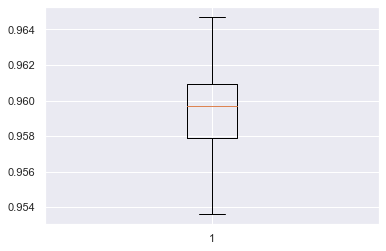

In [135]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=dtree_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.954 to 0.964

In [136]:
# predict on X test

dtree_gridsearch_pred = dtree_gridsearch.predict(X_test)

In [137]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, dtree_gridsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtree_gridsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtree_gridsearch_pred)))

MAE: 0.0524474305573702
MSE: 0.04211478675474251
RMSE: 0.20521887523993135


In [138]:
# model variance check

print('Decision Tree Grid Search R-square on test data is {a}.'.format(a=r2_score(y_test, dtree_gridsearch_pred)))

Decision Tree Grid Search R-square on test data is 0.9664835269109638.


In [139]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=dtree_gridsearch.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=dtree_gridsearch.score(X_test, y_test)))

Training Accuracy is 0.995%
Test Accuracy is 0.966%


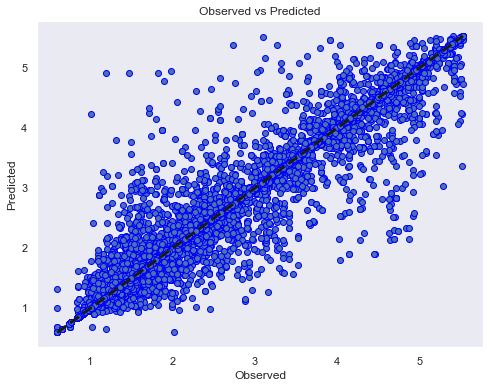

In [140]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, dtree_gridsearch_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can observe that the Predictor variables have a linear relation with the dependent variable, but few data points have more considerable variations; this indicates that few predictor variables observed and predicted variables differences are high. We see that residuals do not form a strong pattern it is randomly and uniformly scattered.

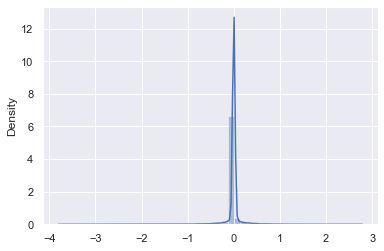

In [143]:
dtree_gridsearch_pred_reshape=dtree_gridsearch_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-dtree_gridsearch_pred_reshape),kde=True,bins=50);

- Residuals looks normally distributed, negatively skewed. 

- Decision Tree Grid Search able to produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 96%. However, residuals scattered across, this indicates that for few data points we hvae higher residuals(difference between acutal vs predicte values are higher).

## Decision Tree Random Search

In [194]:
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(),DecisionTreeRegressor(random_state=1))

# Parameter grid to pass
param_grid = {
    "decisiontreeregressor__max_depth": [16, 18, 20, None],  
    "decisiontreeregressor__min_samples_split": [2, 3, 5, 7, 9],
    "decisiontreeregressor__min_samples_leaf":[1, 2, 5, 7], 
    "decisiontreeregressor__min_impurity_decrease":[0.0, 0.00001, 0.0001, 0.001, 0.01]}

# Type of scoring used to compare parameter combinations
scorer = 'r2'
# neg_mean_squared_error # mse

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, scoring=scorer, n_iter=60, cv=10,
                                  n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("Dtree randomsearch execution time is {a}".format(a=execution_time))
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Dtree randomsearch execution time is 0:2:30
Best parameters are {'decisiontreeregressor__min_samples_split': 7, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__min_impurity_decrease': 0.0, 'decisiontreeregressor__max_depth': None} with CV score=0.9643852417541396:


In [195]:
# Creating new pipeline with best parameters
dtree_randomsearch = make_pipeline(MinMaxScaler(),DecisionTreeRegressor(random_state=1,
                                              max_depth=None, min_impurity_decrease=0.0,
                                              min_samples_leaf=1, min_samples_split=9))
# Fit the model on training data
dtree_randomsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(min_samples_split=9, random_state=1))])

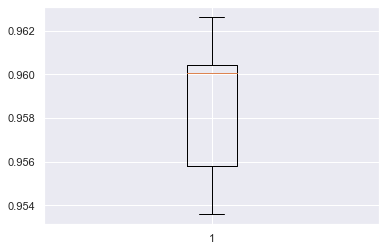

In [196]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=dtree_randomsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.954 to 0.962

In [197]:
# predict on X test

dtree_randomsearch_pred = dtree_randomsearch.predict(X_test)

In [198]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, dtree_randomsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtree_randomsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtree_randomsearch_pred)))

MAE: 0.04712850121487694
MSE: 0.04137784696058185
RMSE: 0.20341545408493883


In [199]:
# model variance check

print('Decision Tree Random Search R-square on test data is {a}.'.format(a=r2_score(y_test, dtree_randomsearch_pred)))

Decision Tree Random Search R-square on test data is 0.9670700102979762.


In [200]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=dtree_randomsearch.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=dtree_randomsearch.score(X_test, y_test)))

Training Accuracy is 0.997%
Test Accuracy is 0.967%


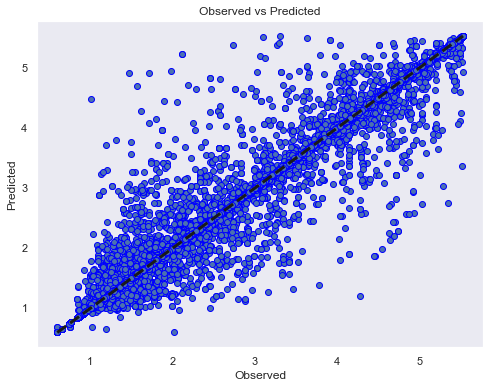

In [201]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, dtree_randomsearch_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can observe that the Predictor variables have a linear relation with the dependent variable, but few data points have more considerable variations. This indicates that few predictor variables observed and predicted variables differences are high. We see that residuals do not form a strong pattern it is randomly and uniformly scattered.

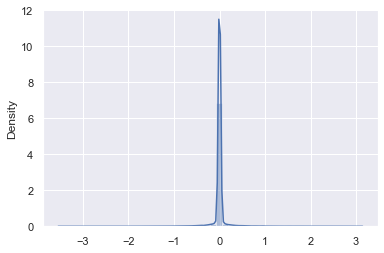

In [202]:
dtree_randomsearch_pred_reshape=dtree_randomsearch_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-dtree_randomsearch_pred_reshape),kde=True,bins=50);

-  Residuals looks normally distributed, slightly negatively skewed. 

- Decision Tree Random Search able to produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 97%. However, residuals scattered across, this indicates that for few data points we hvae higher residuals(difference between acutal vs predicte values are higher).
- Decision Tree Random search parameters is slightly better than Grid Search, this is due to search space for parameters grid.

## Extra Tree Grid Search

In [157]:
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), ExtraTreesRegressor(random_state=1, bootstrap=True,
                                                         oob_score=True))

# Parameter grid to pass
param_grid = {"extratreesregressor__max_depth": [16, 18, None], 
    "extratreesregressor__min_samples_split": [2, 4, 7, 9],
    "extratreesregressor__min_samples_leaf":[1, 2, 5, 7]} 
    #"extratreesregressor__min_impurity_decrease":[0.0, 0.0001,0.001]}
    #"extratreesregressor__n_estimators":[100, 200, 300]}

# Type of scoring used to compare parameter combinations
scorer = 'r2'
# neg_mean_squared_error # mse

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)


print("Extra Tree gridsearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

Extra Tree gridsearch execution time is 0:16:40
Best Parameters:{'extratreesregressor__max_depth': None, 'extratreesregressor__min_samples_leaf': 1, 'extratreesregressor__min_samples_split': 2} 
Score: 0.9892469868296188


<div class="alert alert-block alert-info">
<b>Note:</b><br>

- Above parameters overfits the model. After few trail and runs below are the parameters which will reduce the overfitting and compartively low errors(residuals).
</div>


In [115]:
# Creating new pipeline with best parameters
extra_tree_gridsearch = make_pipeline(
    MinMaxScaler(),
    ExtraTreesRegressor(random_state=1, max_depth=None, min_samples_leaf=5, min_samples_split=7))
# Fit the model on training data
extra_tree_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('extratreesregressor',
                 ExtraTreesRegressor(min_samples_leaf=5, min_samples_split=7,
                                     random_state=1))])

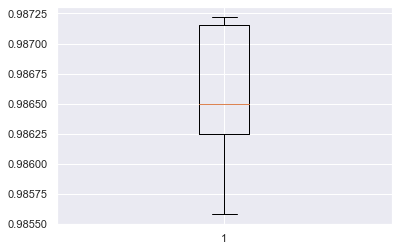

In [165]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=extra_tree_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.98550 to 0.98725

In [118]:
# predict on X test

extra_tree_gridsearch_pred = extra_tree_gridsearch.predict(X_test)

In [167]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, extra_tree_gridsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, extra_tree_gridsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, extra_tree_gridsearch_pred)))

MAE: 0.05835230719991987
MSE: 0.012588787314118891
RMSE: 0.11219976521418791


In [168]:
# model variance check

print('Extra Tree Grid Search R-square on test data is {a}.'.format(a=r2_score(y_test, extra_tree_gridsearch_pred)))

Extra Tree Grid Search R-square on test data is 0.9899813869723618.


In [169]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=extra_tree_gridsearch.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=extra_tree_gridsearch.score(X_test, y_test)))

Training Accuracy is 0.996%
Test Accuracy is 0.990%


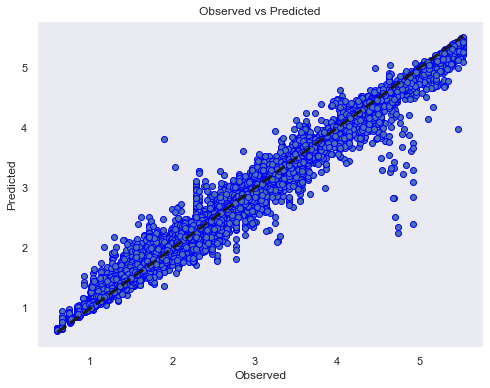

In [170]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, extra_tree_gridsearch_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can observe that the Predictor variables have a linear relation with the dependent variable, few data points have variations. We see that residuals do not form a strong pattern it is randomly and uniformly scattered.

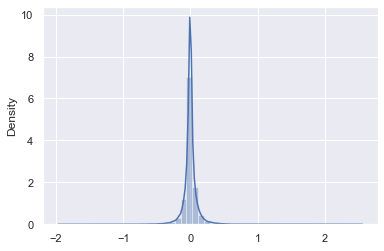

In [171]:
extra_tree_gridsearch_reshape=extra_tree_gridsearch_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-extra_tree_gridsearch_reshape),kde=True,bins=50);

- Residuals are normally distributed.

- Extra Tree Grid Search able to produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 99%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed.

## Extra Tree Random Search

In [172]:
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(), ExtraTreesRegressor(random_state=1, bootstrap=True,
                                                         oob_score=True))

# Parameter grid to pass
param_grid = {"extratreesregressor__max_depth": [14, 16, 18], # do not use None will leads to overfit
    "extratreesregressor__min_samples_split": [2, 4, 7, 9],
    "extratreesregressor__min_samples_leaf":[1, 2, 5, 7],
    #"extratreesregressor__min_impurity_decrease":[0.0, 0.0001,0.001]}
    "extratreesregressor__n_estimators":[200, 300, 400]}

# Type of scoring used to compare parameter combinations
scorer = 'r2'
# neg_mean_squared_error # mse

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, scoring=scorer, n_iter=60, cv=5,
                                  n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("Extra Tree randomsearch execution time is {a}".format(a=execution_time))
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Extra Tree randomsearch execution time is 0:59:43
Best parameters are {'extratreesregressor__n_estimators': 400, 'extratreesregressor__min_samples_split': 2, 'extratreesregressor__min_samples_leaf': 1, 'extratreesregressor__max_depth': 18} with CV score=0.9783844846026387:


<div class="alert alert-block alert-info">
<b>Note:</b><br>

- I have change the max_depth to 18 to avoid overfitting, next time when we run the grid search we should not be using max_depth=None, this cause model to overfit.
</div>


In [174]:
# Creating new pipeline with best parameters
extra_tree_randomsearch = make_pipeline(
    MinMaxScaler(),
    ExtraTreesRegressor(random_state=1, max_depth=18, min_samples_leaf=1, min_samples_split=2,
                       n_estimators=400))
# Fit the model on training data
extra_tree_randomsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_depth=18, n_estimators=400,
                                     random_state=1))])

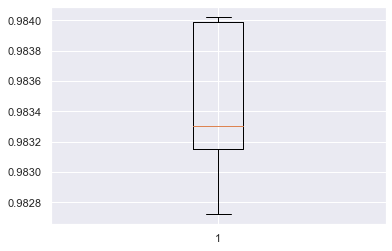

In [175]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=extra_tree_randomsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance of training data varies between 0.9828 to 0.9840

In [176]:
# predict on X test

extra_tree_randomsearch_pred = extra_tree_randomsearch.predict(X_test)

In [177]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, extra_tree_randomsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, extra_tree_randomsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, extra_tree_randomsearch_pred)))

MAE: 0.08308551009745846
MSE: 0.018528931840390412
RMSE: 0.13612101909841262


In [178]:
# model variance check

print('Extra Tree Random Search R-square on test data is {a}.'.format(a=r2_score(y_test, extra_tree_randomsearch_pred)))

Extra Tree Random Search R-square on test data is 0.985254004751025.


In [179]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=extra_tree_randomsearch.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=extra_tree_randomsearch.score(X_test, y_test)))

Training Accuracy is 0.992%
Test Accuracy is 0.985%


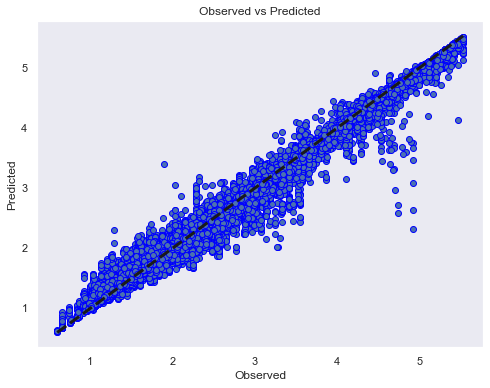

In [180]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, extra_tree_randomsearch_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can observe that the Predictor variables have a linear relation with the dependent variable, few data points have variations. We see that residuals do not form a strong pattern it is randomly and uniformly scattered.

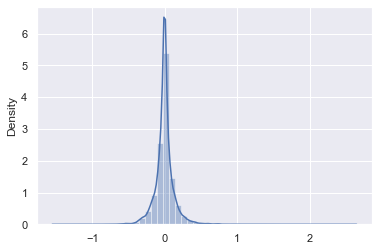

In [181]:
extra_tree_gridsearch_reshape=extra_tree_randomsearch_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-extra_tree_gridsearch_reshape),kde=True,bins=50);

- Residuals normally distributed with slightly righ skewed.

- Extra Tree Random Search able to produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 98%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed with slighly right skewed.

## Random Forest Grid Search

In [183]:
start_base = time.time() # to check execution time

# Parameter grid to pass
pipe = make_pipeline(MinMaxScaler(),RandomForestRegressor(random_state=1,oob_score=True, bootstrap=True))

param_grid = {"randomforestregressor__max_depth": [14, 16, 18],
              #"randomforestregressor__max_features": ['sqrt','log2','auto'],
              "randomforestregressor__min_samples_split": [2, 3, 5],
              "randomforestregressor__min_samples_leaf": [1, 3, 5],
              "randomforestregressor__n_estimators": [100, 150, 200]}

# Type of scoring used to compare parameter combinations
scorer = 'r2'
# neg_mean_squared_error # mse

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("Random Forest gridsearch execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

Random Forest gridsearch execution time is 2:27:37
Best Parameters:{'randomforestregressor__max_depth': 18, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200} 
Score: 0.9808414137124639


In [184]:
# Creating new pipeline with best parameters
rf_gridsearch = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(random_state=1, max_depth=18, min_samples_leaf=1, min_samples_split=2,
                       n_estimators=200))
# Fit the model on training data
rf_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=18, n_estimators=200,
                                       random_state=1))])

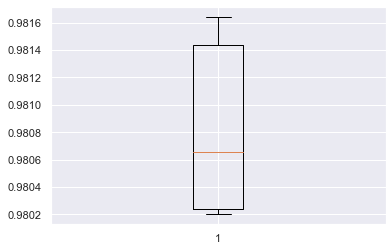

In [185]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=rf_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance of training data varies between 0.9802 to 0.9816

In [186]:
# predict on X test

rf_gridsearch_pred = rf_gridsearch.predict(X_test)

In [187]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, rf_gridsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, rf_gridsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_gridsearch_pred)))

MAE: 0.0738680165140383
MSE: 0.019925262093237132
RMSE: 0.14115687051375547


In [188]:
# model variance check

print('Random Forest Grid Search R-square on test data is {a}.'.format(a=r2_score(y_test, rf_gridsearch_pred)))

Random Forest Grid Search R-square on test data is 0.9841427545477297.


In [189]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=rf_gridsearch.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=rf_gridsearch.score(X_test, y_test)))

Training Accuracy is 0.994%
Test Accuracy is 0.984%


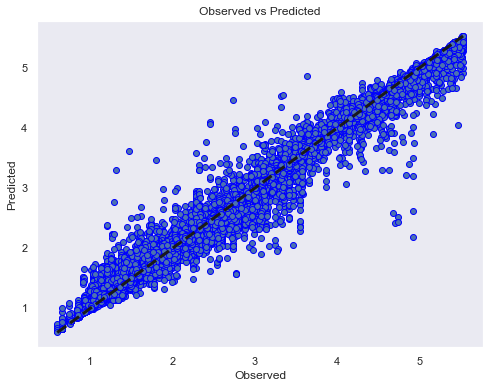

In [190]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, rf_gridsearch_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can observe that the Predictor variables have a linear relation with the dependent variable, few data points have variations. We see that residuals do not form a strong pattern it is randomly and uniformly scattered.

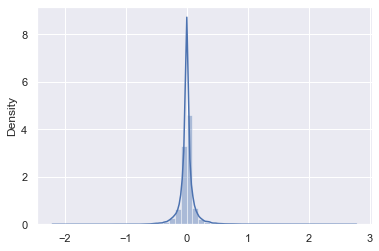

In [191]:
rf_gridsearch_reshape=rf_gridsearch_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-rf_gridsearch_reshape),kde=True,bins=50);

- Residuals normally distributed.

- Random Forest Grid search produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 98%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed.

## Bagging Grid Search

In [203]:
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(MinMaxScaler(),BaggingRegressor(random_state=1,oob_score=True, bootstrap=True))

# Parameter grid to pass
param_grid = {"baggingregressor__max_features": [0.7, 0.8, 0.9, 1],
              "baggingregressor__max_samples":[0.8, 0.9, 1],
              "baggingregressor__n_estimators":[100, 150, 200],
              "baggingregressor__base_estimator": [
        DecisionTreeRegressor(max_depth=10, random_state=1), 
        DecisionTreeRegressor(max_depth=12, random_state=1),
        DecisionTreeRegressor(max_depth=None, random_state=1)]}

# Type of scoring used to compare parameter combinations
scorer = 'r2'
# neg_mean_squared_error # mse

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("Bagging Grid Search execution time is {a}".format(a=execution_time))
print("Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_))

Bagging Grid Search execution time is 1:17:26
Best Parameters:{'baggingregressor__base_estimator': DecisionTreeRegressor(random_state=1), 'baggingregressor__max_features': 0.9, 'baggingregressor__max_samples': 0.9, 'baggingregressor__n_estimators': 100} 
Score: 0.9824885436673169


<div class="alert alert-block alert-info">
<b>Note:</b><br>

- From the above you will not see max_deph because it has selected default of None.
- In the below I will use n_estimators as 200 to increase the model performance score, I did not use n_estimators in Grid search because of the computation time.
</div>


In [204]:
# Creating new pipeline with best parameters

bagging_gridsearch = make_pipeline(MinMaxScaler(),
                                            BaggingRegressor(DecisionTreeRegressor(random_state=1, 
                                                                                     max_depth=None),
                                                              max_features=0.9, max_samples= 0.9,
                                                            n_estimators= 200))

# Fit the model on training data
bagging_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('baggingregressor',
                 BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=1),
                                  max_features=0.9, max_samples=0.9,
                                  n_estimators=200))])

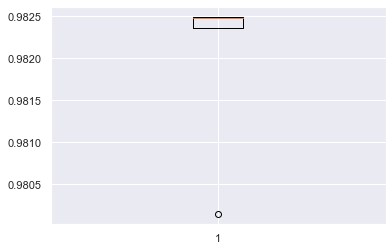

In [205]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.

scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=bagging_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.9805 to 0.9825

In [206]:
# predict on X test

bagging_gridsearch_pred = bagging_gridsearch.predict(X_test)

In [207]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, bagging_gridsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, bagging_gridsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, bagging_gridsearch_pred)))

MAE: 0.06639295750508042
MSE: 0.015324476148048032
RMSE: 0.12379206819521206


In [208]:
# model variance check

print('Bagging Grid Search R-square on test data is {a}.'.format(a=r2_score(y_test, bagging_gridsearch_pred)))

Bagging Grid Search R-square on test data is 0.9878042266862056.


In [209]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=bagging_gridsearch.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=bagging_gridsearch.score(X_test, y_test)))

Training Accuracy is 0.998%
Test Accuracy is 0.988%


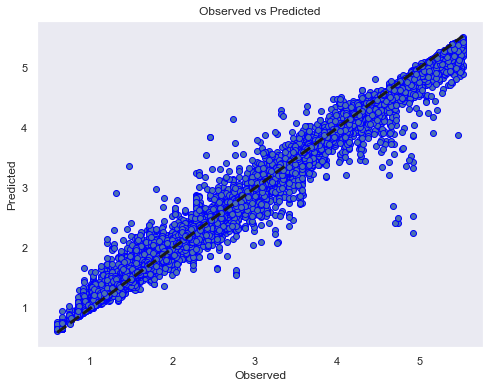

In [210]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, bagging_gridsearch_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can observe that the Predictor variables have a linear relation with the dependent variable, few data points have variations. We see that residuals do not form a strong pattern it is randomly and uniformly scattered.

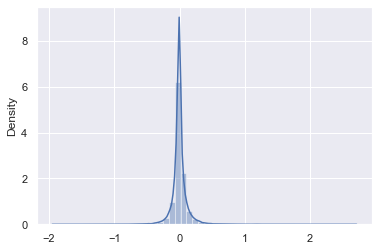

In [211]:
bagging_gridsearch_reshape= bagging_gridsearch_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-bagging_gridsearch_reshape),kde=True,bins=50);

- Residuals are normally distributed.

- Bagging Grid Search produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 99%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed.

## CatBoost Grid Search

In [ ]:
start_base = time.time() # to check execution time

# Creating pipeline
pipe = make_pipeline(
    MinMaxScaler(), CatBoostRegressor(random_state=1, verbose=False))

# Parameter grid to pass
param_grid = {
    "catboostregressor__max_depth": [14, 16, 18], 
    "catboostregressor__l2_leaf_reg": [1, 3, 5], 
    "catboostregressor__learning_rate": [0.001, 0.01, 0.1],
    "catboostregressor__n_estimators": [100, 150, 200]}

# Type of scoring used to compare parameter combinations
scorer = 'r2'
# neg_mean_squared_error # mse

#Calling Halving Grid SearchCV
grid_cv  = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in Halving GrideachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("CatBoost Grid Search execution time is {a}".format(a=execution_time))
print("Best parameters are {} with CV score={}:".format(grid_cv.best_params_, grid_cv.best_score_))

In [48]:
# Creating new pipeline with best parameters

catboost_gridsearch = make_pipeline(MinMaxScaler(),
                                            CatBoostRegressor(random_state=1, verbose= False, max_depth=16, l2_leaf_reg=3, 
                                                             learning_rate=0.01, n_estimators=200))

# Fit the model on training data
catboost_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001F19523E520>)])

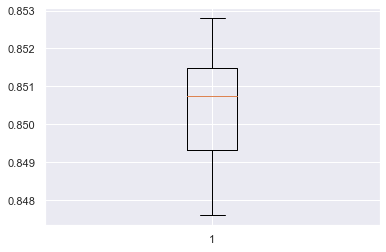

In [49]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.
scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=catboost_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- CatBoost Grid search traning score varies between 0.2455 to 0.2490. Very less training score.

In [50]:
# predict on X test

catboost_gridsearch_pred = catboost_gridsearch.predict(X_test)

In [51]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, catboost_gridsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, catboost_gridsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, catboost_gridsearch_pred)))

MAE: 0.3264742289707737
MSE: 0.18167857328512102
RMSE: 0.4262376957580371


In [52]:
# model variance check

print('CatBoost Grid Search R-square on test data is {a}.'.format(a=r2_score(y_test, catboost_gridsearch_pred)))

CatBoost Grid Search R-square on test data is 0.858204854531655.


## XGBoost Grid Search

In [53]:
start_base = time.time() # to check execution time

pipe = make_pipeline(XGBRegressor(random_state=1,))

param_grid = {'xgbregressor__max_depth':[14, 16, 18],
        'xgbregressor__min_child_weight':[1, 3, 5, 7],
        'xgbregressor__subsample':[0.8, 0.9, 1]}
        #'xgbregressor__colsample_bytree':[0.7, 0.8, 0.9]}    
        #'xgbregressor__objective':['reg:squarederror','rmse','mse','logloss']}

# 'xgbregressor__gamma':[ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
# 'xgbregressor__learning_rate':[0.01, 0.1]
#  'xgbregressor__n_estimators':[100, 200],

# Type of scoring used to compare parameter combinations
scorer = 'r2' 
# neg_mean_squared_error # mse

grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("XGBBoost Grid Search execution time is {a}".format(a=execution_time))
print("Best parameters are {} with CV score={}:".format(grid_cv.best_params_, grid_cv.best_score_))

XGBBoost Grid Search execution time is 0:39:32
Best parameters are {'xgbregressor__max_depth': 16, 'xgbregressor__min_child_weight': 5, 'xgbregressor__subsample': 1} with CV score=0.9855577272684599:


<div class="alert alert-block alert-info">
<b>Note:</b><br>

- Above Grid search parameters overfits the model, I have change the max_depth to 10, min_child_weight to 3 and subsample to 60% to avoid overfitting.
</div>


In [72]:
# Creating new pipeline with best parameters

xgboost_gridsearch = make_pipeline(MinMaxScaler(),
                                            XGBRegressor(random_state=1, max_depth=10, min_child_weight=3, 
                                                             subsample=.6))

# Fit the model on training data
xgboost_gridsearch.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=10, min_child_weight=3, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.6, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

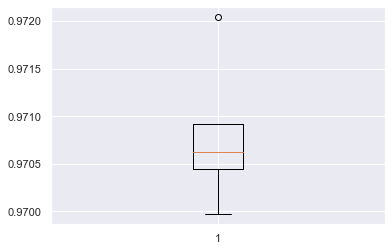

In [73]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.
scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=xgboost_gridsearch, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on the training data varies between 0.970 to 0.9720.

In [74]:
# predict on X test

xgboost_gridsearch_pred = xgboost_gridsearch.predict(X_test)

In [75]:
# model evaluaiton metrics

print('MAE:', metrics.mean_absolute_error(y_test, xgboost_gridsearch_pred))
print('MSE:', metrics.mean_squared_error(y_test, xgboost_gridsearch_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgboost_gridsearch_pred)))

MAE: 0.11405948827467147
MSE: 0.029937943903055916
RMSE: 0.1730258474998921


In [76]:
# model variance check

print('XGBoost Grid Search R-square on test data is {a}.'.format(a=r2_score(y_test, xgboost_gridsearch_pred)))

XGBoost Grid Search R-square on test data is 0.9766342555756704.


In [77]:
# training and test score

print('Training Accuracy is {a:.3f}%'.format(a=xgboost_gridsearch.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=xgboost_gridsearch.score(X_test, y_test)))

Training Accuracy is 0.994%
Test Accuracy is 0.977%


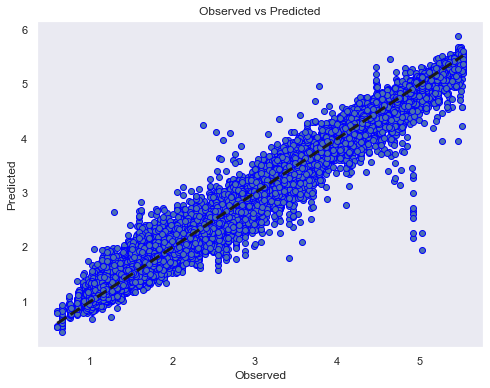

In [78]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, xgboost_gridsearch_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

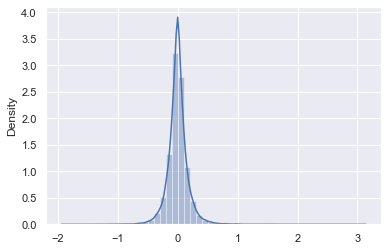

In [80]:
xgboost_gridsearch_pred_reshape= xgboost_gridsearch_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-xgboost_gridsearch_pred_reshape),kde=True,bins=50);

- Residuals are normally distributed.

- XGBoost with modified parameters produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 97%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed.

## HyperOpt Regressor
- **TPE & Anneal Algorithm suggest**

In [81]:
df.head()

,% Silica Feed,day,Ore Pulp Flow,Flotation Column 07 Air Flow,Flotation Column 05 Air Flow,Amina Flow,Flotation Column 06 Air Flow,Flotation Column 07 Level,Starch Flow,Flotation Column 03 Level,Flotation Column 02 Level,Flotation Column 04 Level,Flotation Column 06 Level,Flotation Column 01 Level,Flotation Column 05 Level,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 01 Air Flow,month,% Iron Concentrate,% Silica Concentrate
662744,10.71,23,378.850862,291.086,300.655,266.115444,291.212,354.68100,1096.792542,875.271265,511.782,392.194,377.357,855.519667,359.772000,297.589,297.473,300.110,8,64.65,2.460000
237886,6.26,17,405.723000,299.927,298.758,493.734000,304.598,350.46000,3738.710000,873.403792,453.253,346.488,350.760,455.212000,349.320000,248.826,250.928,249.883,5,64.93,1.910000
154535,20.32,28,403.250000,303.123,302.828,513.813000,293.709,311.75400,2313.480000,498.449000,498.516,479.414,414.089,512.059000,444.961000,299.925,300.723,300.090,4,65.29,2.520000
680219,12.53,27,379.162269,290.075,297.118,389.768000,310.774,178.62355,2199.220000,498.380000,482.005,560.077,537.224,509.357000,168.856154,298.383,298.942,301.112,8,65.17,2.240000
242878,6.26,18,404.201060,300.146,299.868,590.073000,299.557,350.71800,3510.210000,458.498000,460.128,362.716,342.919,448.591000,332.146000,252.624,251.048,249.899,5,62.86,5.215916


In [82]:
# scale the data using standard scaler.

scaler=MinMaxScaler()
subset=df.copy()
subset_scaled=scaler.fit_transform(subset)

scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)
scaled_df.head()

,% Silica Feed,day,Ore Pulp Flow,Flotation Column 07 Air Flow,Flotation Column 05 Air Flow,Amina Flow,Flotation Column 06 Air Flow,Flotation Column 07 Level,Starch Flow,Flotation Column 03 Level,Flotation Column 02 Level,Flotation Column 04 Level,Flotation Column 06 Level,Flotation Column 01 Level,Flotation Column 05 Level,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 01 Air Flow,month,% Iron Concentrate,% Silica Concentrate
0,0.292926,0.733333,0.061354,0.566100,0.598957,0.049048,0.559262,0.370063,0.174211,0.984852,0.486970,0.443766,0.407933,0.990630,0.378693,0.611253,0.655704,0.628650,0.833333,0.436242,0.377282
1,0.154254,0.533333,0.695266,0.613752,0.519833,0.506293,0.633336,0.361351,0.593851,0.982396,0.392283,0.355515,0.358954,0.428998,0.358131,0.365925,0.403471,0.374673,0.333333,0.483221,0.265720
2,0.592396,0.900000,0.636928,0.630977,0.689593,0.546628,0.573080,0.281467,0.367469,0.489318,0.465508,0.612173,0.475577,0.508754,0.546275,0.623005,0.673317,0.628549,0.166667,0.543624,0.389452
3,0.349642,0.866667,0.068700,0.560651,0.451429,0.297444,0.667511,0.006701,0.349320,0.489228,0.438797,0.767920,0.702337,0.504963,0.003125,0.615247,0.663665,0.633716,0.833333,0.523490,0.332657
4,0.154254,0.566667,0.659363,0.614932,0.566131,0.699820,0.605441,0.361884,0.557556,0.436781,0.403405,0.386849,0.344514,0.419708,0.324347,0.385032,0.404121,0.374754,0.333333,0.135906,0.936291


In [83]:
# define X and y variable

X = scaled_df.drop(['% Silica Concentrate'],axis=1)
y = scaled_df['% Silica Concentrate']

In [84]:
# split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape)

(77432, 20) (33186, 20)


### Gradient Boost HyperOpt

In [85]:
from hyperopt import hp, fmin, tpe

# Run Bayesian Optimization from hyperopt
start_base = time.time() # to check execution time

space_lr = {'max_depth': hp.randint('max_depth', 4, 10),
            'max_features': hp.uniform('max_features', 0.7, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 1),
            'n_estimators': hp.randint('n_estimators', 80,200),
            'subsample': hp.uniform('subsample',0.7, 1)}

def gbm_cl_bo2(params):
    params = {'max_depth': params['max_depth'],
              'max_features': params['max_features'],
              'learning_rate': params['learning_rate'],
              'n_estimators': params['n_estimators'],
              'subsample': params['subsample']}
    
    gbm_bo2 = GradientBoostingRegressor(random_state=101, **params)
    
    best_score = -cross_val_score(gbm_bo2, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    
    return best_score
    
gbm_best_param = fmin(fn=gbm_cl_bo2,
                space=space_lr,
                max_evals=25,
                rstate=np.random.RandomState(101),
                algo=tpe.suggest) # OR YOU CAN USE algo=anneal.suggest

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("Execution time is {a}".format(a=execution_time))
print(gbm_best_param)

100%|█████████████████████████████████████████████| 25/25 [33:54<00:00, 81.38s/trial, best loss: 0.0013618839389693785]
Execution time is 0:33:54
{'learning_rate': 0.35648732522856136, 'max_depth': 9, 'max_features': 0.9998919772525278, 'n_estimators': 165, 'subsample': 0.9985016816300355}


In [86]:
# Creating new pipeline with best parameters
gb_hyperopt= GradientBoostingRegressor(random_state=101, learning_rate=0.36, max_depth=9, max_features=0.99,
                                      n_estimators=165, subsample=0.99)

# Fit the model on training data
gb_hyperopt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.36, max_depth=9, max_features=0.99,
                          n_estimators=165, random_state=101, subsample=0.99)

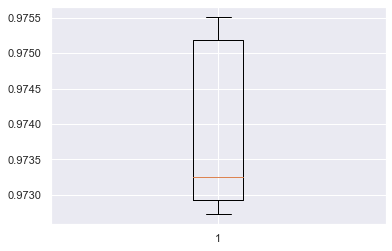

In [87]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.
scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=gb_hyperopt, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on the training data varies between 0.9730 to 9775.

In [88]:
#predict on test data

gb_hyperopt_pred = gb_hyperopt.predict(X_test)

In [89]:
print('MAE:', metrics.mean_absolute_error(y_test, gb_hyperopt_pred))
print('MSE:', metrics.mean_squared_error(y_test, gb_hyperopt_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gb_hyperopt_pred)))

MAE: 0.02058484578912219
MSE: 0.00107374156072763
RMSE: 0.03276799598278219


In [90]:
print('Gradient Boost HyperOpt R-square on test data is {a:.2f}%.'.format(a=r2_score(y_test, gb_hyperopt_pred)))

Gradient Boost HyperOpt R-square on test data is 0.98%.


In [91]:
print('Training Accuracy is {a:.3f}%'.format(a=gb_hyperopt.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=gb_hyperopt.score(X_test, y_test)))

Training Accuracy is 0.997%
Test Accuracy is 0.980%


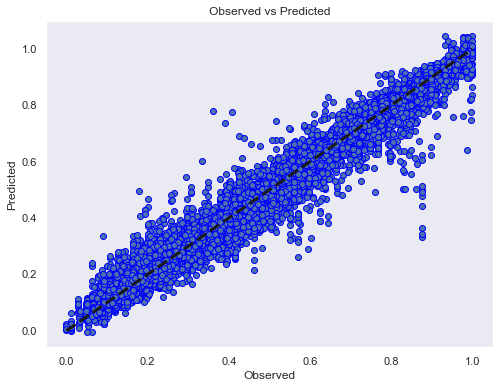

In [92]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, gb_hyperopt_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

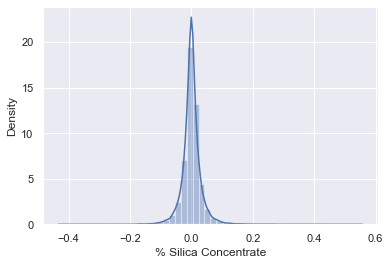

In [93]:
#gb_hyperopt_pred_reshape= gb_hyperopt_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-gb_hyperopt_pred),kde=True,bins=50);

- Residuals are normally distributed.

- Grdeint Boost HyperOpt produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 98%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed.

### CatBoost HyperOpt

In [95]:
from hyperopt import hp, fmin, tpe

# Run Bayesian Optimization from hyperopt
start_base = time.time() # to check execution time

space_lr = {'max_depth': hp.randint('max_depth', 6, 14),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.6, 1),
            'learning_rate': hp.uniform('learning_rate', 0.01, 1),
            'n_estimators': hp.randint('n_estimators', 100,200)}
            #'l2_leaf_reg': hp.randint('l2_leaf_reg',1, 10)}

def ctb_hyperopt(params):
    params = {'max_depth': params['max_depth'],
              'colsample_bylevel': params['colsample_bylevel'],
              'learning_rate': params['learning_rate'],
              'n_estimators': params['n_estimators']}
              #'l2_leaf_reg': params['l2_leaf_reg']}
    
    ctb_hyperopt = CatBoostRegressor(random_state=101, **params)
    
    best_score = -cross_val_score(ctb_hyperopt, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    
    return best_score
    
ctb_best_param = fmin(fn=ctb_hyperopt,
                space=space_lr,
                max_evals=25,
                rstate=np.random.RandomState(101),
                algo=tpe.suggest) # OR YOU CAN USE algo=anneal.suggest

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("CatBoost HyperOpt Execution time is {a}".format(a=execution_time))
print(ctb_best_param)

100%|█████████████████████████████████████████████| 25/25 [19:48<00:00, 47.53s/trial, best loss: 0.0018130706330937263]
CatBoost HyperOpt Execution time is 0:19:48
{'colsample_bylevel': 0.6773824037019565, 'learning_rate': 0.33773879284252517, 'max_depth': 12, 'n_estimators': 197}


In [96]:
# Creating new pipeline with best parameters
cat_hyperopt= CatBoostRegressor(random_state=101, colsample_bylevel=0.68, learning_rate=0.34, max_depth=12, 
                                      n_estimators=197, verbose=False)

# Fit the model on training data
cat_hyperopt.fit(X_train, y_train)

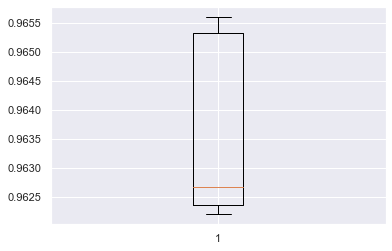

In [97]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.
scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=cat_hyperopt, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.9625 to 0.9655

In [98]:
#predict on test data

cat_hyperopt_pred = cat_hyperopt.predict(X_test)

In [99]:
print('MAE:', metrics.mean_absolute_error(y_test, cat_hyperopt_pred))
print('MSE:', metrics.mean_squared_error(y_test, cat_hyperopt_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, cat_hyperopt_pred)))

MAE: 0.027537611925808524
MSE: 0.0015935057007099745
RMSE: 0.03991873871642207


In [100]:
print('Cat Boost HyperOpt R-square on test data is {a:.2f}%.'.format(a=r2_score(y_test, cat_hyperopt_pred)))

Cat Boost HyperOpt R-square on test data is 0.97%.


In [101]:
print('Training Accuracy is {a:.3f}%'.format(a=cat_hyperopt.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=cat_hyperopt.score(X_test, y_test)))

Training Accuracy is 0.988%
Test Accuracy is 0.970%


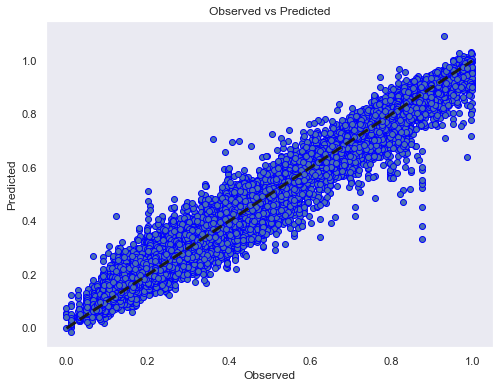

In [102]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, cat_hyperopt_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

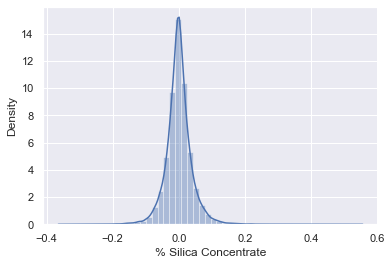

In [103]:
#cat_hyperopt_pred_reshape= cat_hyperopt_pred.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-cat_hyperopt_pred),kde=True,bins=50);

- Residuals are normally distributed.

- Cat Boost HyperOpt produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 97%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed.

### LGBM HyperOpt

In [104]:
from hyperopt import hp, fmin, tpe

# Run Bayesian Optimization from hyperopt
start_base = time.time() # to check execution time

space_lr = {'max_depth': hp.randint('max_depth', 2, 20),
            'num_leaves': hp.randint('num_leaves', 2, 20),
            'learning_rate': hp.uniform('learning_rate', 0.01, 1),
            'n_estimators': hp.randint('n_estimators', 100, 500)}
           
def lgbm_hyperopt(params):
    params = {'max_depth': params['max_depth'],
              'num_leaves': params['num_leaves'],
              'learning_rate': params['learning_rate'],
              'n_estimators': params['n_estimators']}
                  
    lgbm_hyperopt = LGBMRegressor(random_state=101, **params)
    
    best_score = -cross_val_score(lgbm_hyperopt, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    
    return best_score
    
lgbm_best_param = fmin(fn=lgbm_hyperopt,
                space=space_lr,
                max_evals=50,
                rstate=np.random.RandomState(101),
                algo=anneal.suggest) # OR YOU CAN USE algo=tpe.suggest

end_base = time.time()
execution_time = exec_time(start_base,end_base)

print("LGBM HyperOpt Execution time is {a}".format(a=execution_time))
print(lgbm_best_param)

100%|███████████████████████████████████████████████| 50/50 [02:11<00:00,  2.64s/trial, best loss: 0.00194363788537401]
LGBM HyperOpt Execution time is 0:2:12
{'learning_rate': 0.42666578250362897, 'max_depth': 15, 'n_estimators': 495, 'num_leaves': 16}


In [105]:
# Creating new pipeline with best parameters
lgbm_hyperopt= LGBMRegressor(random_state=101, learning_rate=0.43, max_depth=15, 
                                      n_estimators=495, num_leaves=16)

# Fit the model on training data
lgbm_hyperopt.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.43, max_depth=15, n_estimators=495, num_leaves=16,
              random_state=101)

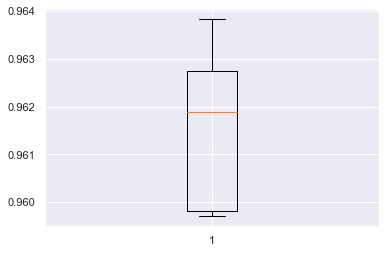

In [106]:
# K-Folds cross-validator provides dataset indices to split data into train/validation sets.
# Split dataset into k consecutive stratified folds (without shuffling by default).
# Each fold is then used once as validation while the k - 1 remaining folds form the training set.
scoring='r2' 
#scoring='neg_mean_squared_error' # this is MSE

cv_result_bfr=cross_val_score(estimator=lgbm_hyperopt, X=X_train, y=y_train, scoring=scoring, cv=5)

#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

- Performance on training data varies between 0.960 to 0.964

In [107]:
#predict on test data

lgbm_hyperopt_pred = lgbm_hyperopt.predict(X_test)

In [108]:
print('MAE:', metrics.mean_absolute_error(y_test, lgbm_hyperopt_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgbm_hyperopt_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgbm_hyperopt_pred)))

MAE: 0.028836622709954286
MSE: 0.001721181590951456
RMSE: 0.04148712560483621


In [109]:
print('LightGBM HyperOpt R-square on test data is {a:.2f}%.'.format(a=r2_score(y_test, lgbm_hyperopt_pred)))

LightGBM HyperOpt R-square on test data is 0.97%.


In [110]:
print('Training Accuracy is {a:.3f}%'.format(a=lgbm_hyperopt.score(X_train, y_train)))
print('Test Accuracy is {b:.3f}%'.format (b=lgbm_hyperopt.score(X_test, y_test)))

Training Accuracy is 0.981%
Test Accuracy is 0.967%


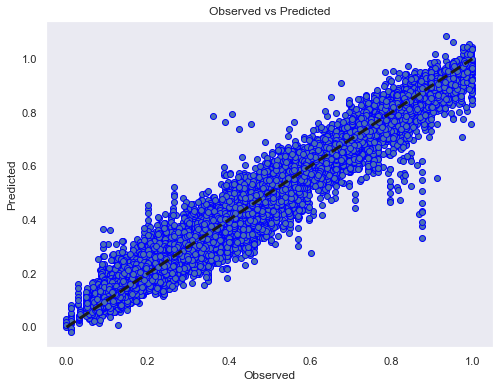

In [111]:
# plot observed and predicted values on the test data
# Create a scatterplot of the real test values versus the predicted values. 

fig, ax = plt.subplots(figsize=(8, 6))
#y_pred=y_test_pred
ax.scatter(y_test, lgbm_hyperopt_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

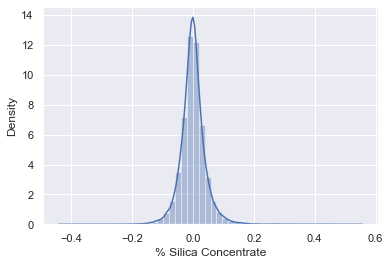

In [112]:
#lgbm_hyperopt_pred_reshape= lgbm_hyperopt.reshape(33186,1)

# Plot a histogram of the residuals and make sure it looks normally distributed.
# Use either seaborn distplot, or just plt.hist().

sns.distplot((y_test-lgbm_hyperopt_pred),kde=True,bins=50);

- Residuals are normally distributed.

- LGBM HyperOpt produced genaralized model with good training and test score, error metrics we can observe that the erros scores are low. R-squared  able to explain variance in % Silica Concentrate by 97%. We do not see any patterns in observed vs predicted variables, it is randomly and uniformly scattered. Residuals are normally distributed.

--------------

# Compare Models Performance.

In [178]:
# set decimals place to 3.
pd.set_option('precision', 3)

data = {'Model': ["Decision Tree Grid Search", "Decision Tree Random Search", "Extra Tree Grid Search", "Extra Tree Random Search",
"Random Froest Grid Search", "Bagging Grid Search", "CatBoost Grid Search", "Gradient Boost HyperOpt", "CatBoost HyperOpt",
                  "LGBM HyperOpt"],
        
        'Training Accuracy': [0.995, 0.997, 0.996, 0.992, 0.994, 0.998, 0.994, 0.997, 0.988, 0.981],
        'Test Accuracy': [0.966, 0.967, 0.990, 0.985, 0.984, 0.988, 0.977, 0.980, 0.970, 0.967],
        'R Square': [0.966, 0.967, 0.990, 0.985, 0.984, 0.988, 0.977, 0.980, 0.970, 0.970],
        'MAE': [0.052, 0.047, 0.058, 0.083, 0.074, 0.066, 0.114, 0.021, 0.028, 0.029],
        'MSE': [0.042, 0.041, 0.013, 0.019, 0.020, 0.015, 0.030, 0.001, 0.002, 0.002],
        'RMSE': [0.205, 0.203, 0.112, 0.136, 0.141, 0.124, 0.173, 0.033, 0.040, 0.041]}
Model_comparison_frame = pd.DataFrame(data, columns = ['Model', 'Training Accuracy', 'Test Accuracy', 'R Square',
                                                'MAE','MSE','RMSE'])

# sort the data by highest test score, then low error metrics and then highest R square
Model_comparison_frame.sort_values(['Test Accuracy', 'MAE','RMSE','R Square'],ascending=[False, True, True, False], inplace=True)

# reset the index column.
Model_comparison_frame = Model_comparison_frame.reset_index(drop=True)
Model_comparison_frame.style.background_gradient(subset=(['Test Accuracy', 'MAE','RMSE','R Square']),cmap='Blues')

,Model,Training Accuracy,Test Accuracy,R Square,MAE,MSE,RMSE
0,Extra Tree Grid Search,0.996,0.990,0.990,0.058,0.013,0.112
1,Bagging Grid Search,0.998,0.988,0.988,0.066,0.015,0.124
2,Extra Tree Random Search,0.992,0.985,0.985,0.083,0.019,0.136
3,Random Froest Grid Search,0.994,0.984,0.984,0.074,0.020,0.141
4,Gradient Boost HyperOpt,0.997,0.980,0.980,0.021,0.001,0.033
5,CatBoost Grid Search,0.994,0.977,0.977,0.114,0.030,0.173
6,CatBoost HyperOpt,0.988,0.970,0.970,0.028,0.002,0.040
7,LGBM HyperOpt,0.981,0.967,0.970,0.029,0.002,0.041
8,Decision Tree Random Search,0.997,0.967,0.967,0.047,0.041,0.203
9,Decision Tree Grid Search,0.995,0.966,0.966,0.052,0.042,0.205


- From the above model comparision we can observe that Extra Tree Grid search produced good test score with 99% accuracy and R square at 99% and MSE and RMSE at 0.013 and 0.112. The Second best model is Bagging Grid Search and Extra Tree Random Search.

---------------

# Feature Importance from the Extra Tree Grid Search

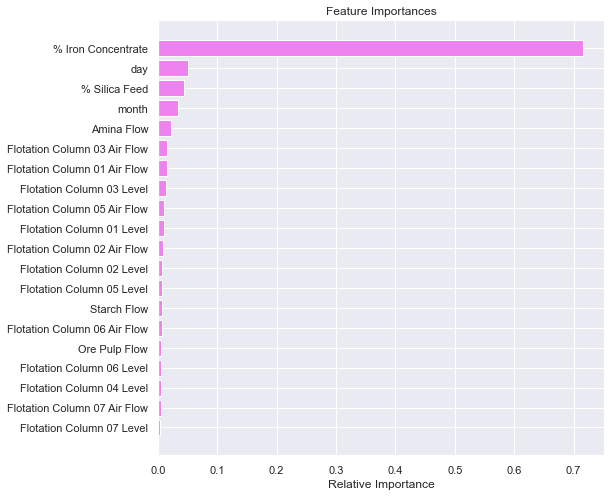

In [116]:
feature_names = X_train.columns
#importances = extra_tree_gridsearch[1].feature_importances_
importances= np.mean([tree.feature_importances_ for tree in extra_tree_gridsearch[1].estimators_], axis=0)

indices = np.argsort(importances)

plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- From the above we can observe that % Iron Concentration is the most important feature to predict the % Silica Concentrate, followed by day, % Silica Feed, month and so on. Least important features are Floatation Columnb 07 Level, Floatation Columnb 07 Air Flow and so on. 

------------

# Prediction Analysis on Test Data.

In [153]:
# lets create a copy of x_test so that we can copy the column names
X_test_copy=X_test.copy()

In [154]:
# get the predicted values and tranform in to dataframe.

extra_tree_gridsearch_pred_df = pd.DataFrame(extra_tree_gridsearch_pred, columns=['predicted % Silica Concentrate'])

In [155]:
# calcualte residuals. (difference between actual vs predicted)

residuals_check=y_test-extra_tree_gridsearch_pred
residuals_check.head()

0    0.18
1   -0.00
2    0.00
3   -0.01
4   -0.00
Name: % Silica Concentrate, dtype: float64

In [152]:
# series to Data frame of residuals

residuals_df=pd.DataFrame({'Prediction difference':residuals_check.values})
residuals_df.head()

,Prediction difference
0,0.18
1,-0.00
2,0.00
3,-0.01
4,-0.00


In [156]:
# lets comnbine all the 4 of them from X_test we take all the column.
# will join the residuals and then predicted value
# in order to join all the below we have to reset_index column.

X_test_copy.reset_index(drop=True, inplace=True)
residuals_df.reset_index(drop=True, inplace=True)
extra_tree_gridsearch_pred_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [157]:
# concantenate or join above in to a data frame.

pd.options.display.float_format = '{:,.2f}'.format
test_final=pd.concat([X_test_copy, y_test, extra_tree_gridsearch_pred_df, residuals_df], axis=1)
test_final

,% Silica Feed,day,Ore Pulp Flow,Flotation Column 07 Air Flow,Flotation Column 05 Air Flow,Amina Flow,Flotation Column 06 Air Flow,Flotation Column 07 Level,Starch Flow,Flotation Column 03 Level,Flotation Column 02 Level,Flotation Column 04 Level,Flotation Column 06 Level,Flotation Column 01 Level,Flotation Column 05 Level,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 01 Air Flow,month,% Iron Concentrate,% Silica Concentrate,predicted % Silica Concentrate,Prediction difference
0,0.15,0.17,0.66,0.61,0.55,0.66,0.61,0.18,0.54,0.36,0.37,0.31,0.22,0.37,0.23,0.35,0.66,0.61,0.50,0.38,0.86,0.68,0.18
1,0.41,0.13,0.59,0.34,0.84,0.61,0.33,0.45,0.27,0.87,0.95,0.47,0.77,0.92,0.46,0.34,0.40,0.38,0.17,0.62,0.23,0.23,-0.00
2,0.59,0.37,0.49,0.64,0.58,0.47,0.58,0.36,0.15,0.43,0.40,0.36,0.36,0.40,0.34,0.38,0.40,0.37,0.33,0.64,0.25,0.24,0.00
3,0.37,0.50,0.06,0.61,0.66,0.20,0.65,0.55,0.49,0.62,0.49,0.57,0.87,0.52,0.47,0.61,0.68,0.63,0.83,0.55,0.11,0.11,-0.01
4,0.72,0.20,0.52,0.63,0.48,0.31,0.62,0.33,0.67,0.42,0.38,0.40,0.34,0.40,0.32,0.38,0.40,0.38,0.33,0.60,0.31,0.32,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33181,0.40,0.73,0.59,0.35,0.35,0.47,0.35,0.70,0.58,0.36,0.30,0.63,0.62,0.33,0.63,0.36,0.39,0.37,0.67,0.75,0.11,0.12,-0.00
33182,0.15,0.83,0.66,0.62,0.59,0.52,0.57,0.46,0.51,0.41,0.47,0.62,0.47,0.48,0.79,0.35,0.66,0.63,0.33,0.55,0.16,0.17,-0.00
33183,0.28,0.70,0.16,0.59,0.49,0.41,0.60,0.36,0.43,0.40,0.45,0.58,0.06,0.95,0.41,0.62,0.65,0.62,0.83,0.56,0.08,0.10,-0.01
33184,0.43,0.47,0.43,0.59,0.54,0.54,0.58,0.60,0.64,0.50,0.48,0.65,0.55,0.50,0.55,0.62,0.68,0.63,0.67,0.57,0.23,0.22,0.01


------------

# Insights

- 1 Unit increase in Silica Feed will increase the log odds of Silica Concentrate by 90%.
- Conversely, a 1 Unit increase in Flotation Column 03 Level will decrease the log odds of Silica Concentrate by 50%. Similarly, we can interpret the other variables from the Linear regression stats model.
- As we observed in the EDA, during the 4th to 6th and 13th to 14th, and 18th to 20th day of the month, there is an increase in % Silica Concentrate. However, we need more insight from this as what leads to a rise in the Silica concentrate during these days, is it because of high production without the quality check or environmental effect.
- Between mid of May to Mid of August month percent of Silica Concentration is less, when we pass August month we can see the percent of Silica increases significantly. We need more insight from this as what leads to increase in perecent of silica after July month.
- Amina Flow and Silica Feed have a strong positive correlation. This indicates that increases in these variables will increase the % of Silica Concentrate, leading to Iron Ore Concentration's impurity.
- Flotation Colum 03 Air Flow, Floatation Column 01 Air Flow Floatation Column 05 Level and so on negatively correlated. This indicates that increases in these variables will decrease the % of Silica concentrate, which leads to purity of Iron ore concentration.
- Amina Flow is one of the significant contributors to the impurity of the Iron ore concentrate; Amina Flow should be minimized.

# The End

-----------